# **DSLM Predictive Project: QuestDice**


## **0. Import Libraries**

In [1]:
# import needed libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

############################################ FEATURE SELECTION ############################################
#!pip install scipy
import scipy.stats as stats
from scipy.stats import chi2_contingency # filter method
from sklearn.feature_selection import RFE # wrapper method
from sklearn.linear_model import LogisticRegression #(This is one possible model to apply inside RFE)
from sklearn.linear_model import LassoCV # embedded method
from sklearn.tree import DecisionTreeClassifier # embedded method

import warnings
warnings.filterwarnings('ignore')

## **1. Data Exploration**: Understand the data and extract meaningful insights





### 1.1  Basic Exploration



In [3]:
#Import the train dataset and define the index as the 'Cust_ID'
data = pd.read_csv('train.csv')
data = data.set_index('Cust_ID')
data.head()

Buy_product                    Name Newsletter_Subscription  \
Cust_ID                                                                
1                  0       Ms. Nicole Clarke                     yes   
2                  1         Mr. Jesse Scott                     yes   
3                  0  Mr. Christopher Carter                     yes   
4                  1     Ms. Jennifer Morgan                     yes   
5                  1       Mr. Michael White                     yes   

         Year_Birth   Membership Preferred_Game_Genre  FidelityPoints  \
Cust_ID                                                                 
1            1974.0      Premium             Strategy            4907   
2            1965.0      Premium             Strategy            6724   
3            1973.0      Premium             Strategy            4365   
4            1993.0  Non-Premium                Party            3849   
5            1989.0      Premium             Strategy            5376   

         S1_GameplayExperience  S2_GameMechanics  S3_GameBalance  ...  \
Cust_ID                                                           ...   
1                            3                 4               1  ...   
2                            1                 1               1  ...   
3                            3                 3               3  ...   
4                            1                 1               1  ...   
5                            2                 2               3  ...   

         S5_MaterialQuality  S6_ValueForPrice  S7_Artwork_Design  \
Cust_ID                                                            
1                         4                 3                  4   
2                         5                 3                  4   
3                         1                 4                  4   
4                         4                 4                  5   
5                         5                 5                  5   

         S8_ThemeIntegration  S9_PlayerIteration  S10_LevelAdjust  \
Cust_ID                                                             
1                          3                   3                3   
2                          5                   5                5   
3                          3                   3                2   
4                          4                   4                4   
5                          5                   5                3   

         S11_RuleClarity  S12_StrategicThinking  S13_ReplayValue  \
Cust_ID                                                            
1                      3                      4                3   
2                      5                      1                5   
3                      3                      2                3   
4                      4                      4                4   
5                      4                      1                3   

         S14_Recommendation  
Cust_ID                      
1                         4  
2                         2  
3                         1  
4                         3  
5                         5  

[5 rows x 21 columns]

In [4]:
#Check for duplicates
data[data.duplicated()]

Buy_product                  Name Newsletter_Subscription  \
Cust_ID                                                              
8196               1      Ms. Abigail York                     yes   
9177               0   Ms. Abigail Kennedy                     yes   
9418               1  Ms. Abigail Buchanan                     yes   

         Year_Birth   Membership Preferred_Game_Genre  FidelityPoints  \
Cust_ID                                                                 
8196         1995.0  Non-Premium                Party            5098   
9177         1991.0      Premium             Thematic            5932   
9418         1972.0      Premium                Party            6769   

         S1_GameplayExperience  S2_GameMechanics  S3_GameBalance  ...  \
Cust_ID                                                           ...   
8196                         5                 5               5  ...   
9177                         3                 3               2  ...   
9418                         5                 4               4  ...   

         S5_MaterialQuality  S6_ValueForPrice  S7_Artwork_Design  \
Cust_ID                                                            
8196                      4                 5                  5   
9177                      3                 3                  3   
9418                      5                 5                  4   

         S8_ThemeIntegration  S9_PlayerIteration  S10_LevelAdjust  \
Cust_ID                                                             
8196                       3                   3                4   
9177                       3                   4                1   
9418                       5                   5                5   

         S11_RuleClarity  S12_StrategicThinking  S13_ReplayValue  \
Cust_ID                                                            
8196                   3                      3                3   
9177                   4                      3                4   
9418                   5                      2                5   

         S14_Recommendation  
Cust_ID                      
8196                      5  
9177                      3  
9418                      1  

[3 rows x 21 columns]

We can see that we have 3 rows that have duplicates.

In [5]:
#Check the number of rows and columns in the dataset
data.shape

(15589, 21)

The dataset contains 15589 rows and 21 columns.

In [6]:
#Check what types of variables we have, and if we have missing values in our data
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15589 entries, 1 to 15589
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Buy_product              15589 non-null  int64  
 1   Name                     15589 non-null  object 
 2   Newsletter_Subscription  15589 non-null  object 
 3   Year_Birth               15394 non-null  float64
 4   Membership               15589 non-null  object 
 5   Preferred_Game_Genre     15589 non-null  object 
 6   FidelityPoints           15589 non-null  int64  
 7   S1_GameplayExperience    15589 non-null  int64  
 8   S2_GameMechanics         15589 non-null  int64  
 9   S3_GameBalance           15589 non-null  int64  
 10  S4_GameLength            15589 non-null  int64  
 11  S5_MaterialQuality       15589 non-null  int64  
 12  S6_ValueForPrice         15589 non-null  int64  
 13  S7_Artwork_Design        15589 non-null  int64  
 14  S8_ThemeIntegration      15

We can verify that we are working with:


*   1 float variables
*   16 integer variables
*   4 object variables


We can see that the **variable `Year_Birth` has some missing values** and that it's a **float variable**. Since the variable will only accomodate integers, it will be more efficient change the variable type to integer. We will do it in the preprocessing phase.


In [7]:
#Check if we have misclassifications in our categorical data (excluding the variable name)
print(data['Newsletter_Subscription'].value_counts(),'\n')
print(data['Membership'].value_counts(),'\n')
data['Preferred_Game_Genre'].value_counts()

Newsletter_Subscription
yes    12548
no      2874
y        167
Name: count, dtype: int64 

Membership
Premium        10756
Non-Premium     4833
Name: count, dtype: int64 



Preferred_Game_Genre
Strategy    7442
Party       7021
Thematic    1126
Name: count, dtype: int64

We can see that for the `Newsletter_Subscription` there are 167 rows that have the value of `y` and should be `yes`.

### 1.2  Basic Statistical Exploration




In [8]:
# Initialize lists to store categorical and numerical variables
categorical_columns = []
numerical_columns = []

# Iterate over columns
for column in data.columns:
    # Check if the column data type is object (categorical)
    if data[column].dtype == 'object':
        categorical_columns.append(column)
    # Check if the column data type is numeric (int or float)
    elif data[column].dtype in ['int64', 'float64']:
        numerical_columns.append(column)


# Print identified categorical, numerical, and date columns
print("Categorical columns:", categorical_columns)
print("Numerical columns:", numerical_columns)

Categorical columns: ['Name', 'Newsletter_Subscription', 'Membership', 'Preferred_Game_Genre']
Numerical columns: ['Buy_product', 'Year_Birth', 'FidelityPoints', 'S1_GameplayExperience', 'S2_GameMechanics', 'S3_GameBalance', 'S4_GameLength', 'S5_MaterialQuality', 'S6_ValueForPrice', 'S7_Artwork_Design', 'S8_ThemeIntegration', 'S9_PlayerIteration', 'S10_LevelAdjust', 'S11_RuleClarity', 'S12_StrategicThinking', 'S13_ReplayValue', 'S14_Recommendation']


We are removing the `Buy_product` columns since it will not be used in the following analysis.

In [9]:
numerical_columns.remove('Buy_product')


#### 1.2.1 Numerical Variables

In [10]:
#Get the main descriptive statistics for all the numeric variables
data.describe()

Buy_product    Year_Birth  FidelityPoints  S1_GameplayExperience  \
count  15589.000000  15394.000000    15589.000000           15589.000000   
mean       0.543781   1981.706444     5022.593816               2.841619   
std        0.498096     15.179042     1027.962379               1.388624   
min        0.000000   1936.000000      409.000000               0.000000   
25%        0.000000   1970.000000     4445.000000               2.000000   
50%        1.000000   1981.000000     5088.000000               3.000000   
75%        1.000000   1994.000000     5649.000000               4.000000   
max        1.000000   2014.000000     6950.000000               5.000000   

       S2_GameMechanics  S3_GameBalance  S4_GameLength  S5_MaterialQuality  \
count      15589.000000    15589.000000   15589.000000        15589.000000   
mean           2.997242        2.844570       2.986016            3.245109   
std            1.518994        1.436948       1.299438            1.327026   
min            0.000000        0.000000       1.000000            0.000000   
25%            2.000000        2.000000       2.000000            2.000000   
50%            3.000000        3.000000       3.000000            3.000000   
75%            4.000000        4.000000       4.000000            4.000000   
max            5.000000        5.000000       5.000000            6.000000   

       S6_ValueForPrice  S7_Artwork_Design  S8_ThemeIntegration  \
count      15589.000000       15589.000000         15589.000000   
mean           3.374816           3.506383             3.454231   
std            1.352417           1.319565             1.310343   
min            0.000000           1.000000             0.000000   
25%            2.000000           3.000000             2.000000   
50%            4.000000           4.000000             4.000000   
75%            4.000000           5.000000             5.000000   
max            5.000000           5.000000             5.000000   

       S9_PlayerIteration  S10_LevelAdjust  S11_RuleClarity  \
count        15589.000000     15589.000000     15589.000000   
mean             3.459683         3.470845         3.700558   
std              1.268130         1.293873         1.158644   
min              1.000000         0.000000         1.000000   
25%              3.000000         2.000000         3.000000   
50%              4.000000         4.000000         4.000000   
75%              4.000000         5.000000         5.000000   
max              5.000000         5.000000         5.000000   

       S12_StrategicThinking  S13_ReplayValue  S14_Recommendation  
count           15589.000000     15589.000000        15589.000000  
mean                3.327282         3.692347            3.347360  
std                 1.266872         1.154437            1.300452  
min                 1.000000         1.000000            0.000000  
25%                 3.000000         3.000000            2.000000  
50%                 3.000000         4.000000            3.000000  
75%                 4.000000         5.000000            4.000000  
max                 5.000000         5.000000            5.000000

From above we can conclude that the **variable `S5_MaterialQuality` has an issue since it has a `max` of 6**, when the valid values should be between 0 and 5.

There also seems to be some incorrect values in the `Year_Birth`variable since the maximum value (2014) would lead to to a current age of 10.

From the 14 questions on the evaluation of the first board game, we can see that the customers consider, in average, that:
  
*   The 3 best qualities of the game are the rules clarity, the replay value and the iteration among the players.
*   The 3 worst qualities of the game are the gameplay experience, the game balance for all players and the game length (although we don't know from the question if the insatisfaction is because it is to long or to short).







In [11]:
# Identify the customers that rated S5_MaterialQuality above 5
filtered_data = data[data['S5_MaterialQuality'] > 5]
print(f'Number of rows with question S5_MaterialQuality with grade above 5: ', filtered_data.shape[0])

Number of rows with question S5_MaterialQuality with grade above 5:  36


This will be changed in the preprocessing phase.

In [12]:
# Identify the customers that have defined an age inferior to 14 as of today
filtered_data = data[data['Year_Birth'] > 2006]
print(f'Number of rows with birth year > 2006 (i.e., younger then 18): ', filtered_data.shape[0])

Number of rows with birth year > 2006 (i.e., younger then 18):  813


We will assume that either the customers are really younger (maybe 14 is a plausible age to buy online with the help of a parent) or that the customer didn't want to share the birth year. Either way, we will keep the values as they are (will only need to deal with the NAs in the preprocessing phase).

#### 1.2.2 Categorical Variables

In [13]:
# Statistical Analysis for Categorical Features
data[categorical_columns].describe()

Name Newsletter_Subscription Membership  \
count               15589                   15589      15589   
unique              14227                       3          2   
top     Mr. Michael Smith                     yes    Premium   
freq                    9                   12548      10756   

       Preferred_Game_Genre  
count                 15589  
unique                    3  
top                Strategy  
freq                   7442

In [14]:
data['Preferred_Game_Genre'].value_counts()

Preferred_Game_Genre
Strategy    7442
Party       7021
Thematic    1126
Name: count, dtype: int64

We can see that:

- `name`: we have some customers with the same name, but they are not duplicates (we removed the duplicates before).
- `Newsletter_Subscription`: about 81.5% of the customers subscribe to the Newsletter.
- `Membership`: about 69% of the customers have a Premium membership
- `Preferred_Game_Genre`: from the 3 game genre, strategy is the most appreciated (47.8%), party is the second one (45%) and thematic is the last one (7.2%).

In [15]:
#validate the gender
data_categorical=data['Name'].str.split().str[0]
g = data_categorical.apply(lambda x: 'M' if 'Mr' in x else 'F')
print(g.value_counts())

Name
F    7985
M    7604
Name: count, dtype: int64


The prevelant gender is female with 51.2%.

#### 1.2.3 Kurtosis Analysis

In [16]:
data[numerical_columns].kurt()

Year_Birth              -0.729800
FidelityPoints           0.260135
S1_GameplayExperience   -0.935544
S2_GameMechanics        -1.077243
S3_GameBalance          -0.967047
S4_GameLength           -1.076583
S5_MaterialQuality      -1.111251
S6_ValueForPrice        -0.540657
S7_Artwork_Design       -0.858889
S8_ThemeIntegration     -0.931811
S9_PlayerIteration      -0.772663
S10_LevelAdjust         -0.864644
S11_RuleClarity         -0.225016
S12_StrategicThinking   -0.812149
S13_ReplayValue         -0.225183
S14_Recommendation      -0.949765
dtype: float64

 A standard normal distribution has a kurtosis of 3, so values higher than that could indicate presence of outliers.

#### 1.2.4 Skewness Analysis

In [17]:
data[numerical_columns].skew()

Year_Birth              -0.003847
FidelityPoints          -0.453779
S1_GameplayExperience   -0.100907
S2_GameMechanics        -0.260705
S3_GameBalance          -0.123610
S4_GameLength           -0.050229
S5_MaterialQuality      -0.171255
S6_ValueForPrice        -0.599498
S7_Artwork_Design       -0.554561
S8_ThemeIntegration     -0.472074
S9_PlayerIteration      -0.503381
S10_LevelAdjust         -0.482952
S11_RuleClarity         -0.750689
S12_StrategicThinking   -0.382588
S13_ReplayValue         -0.745131
S14_Recommendation      -0.358297
dtype: float64

If the skewness is between -0.5 and 0.5, the distribution is approximately symmetric. If the skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. If the skewness is less than -1 or greater than 1, the distribution is highly skewed.

#### 1.2.5 Visualization

**Histograms**

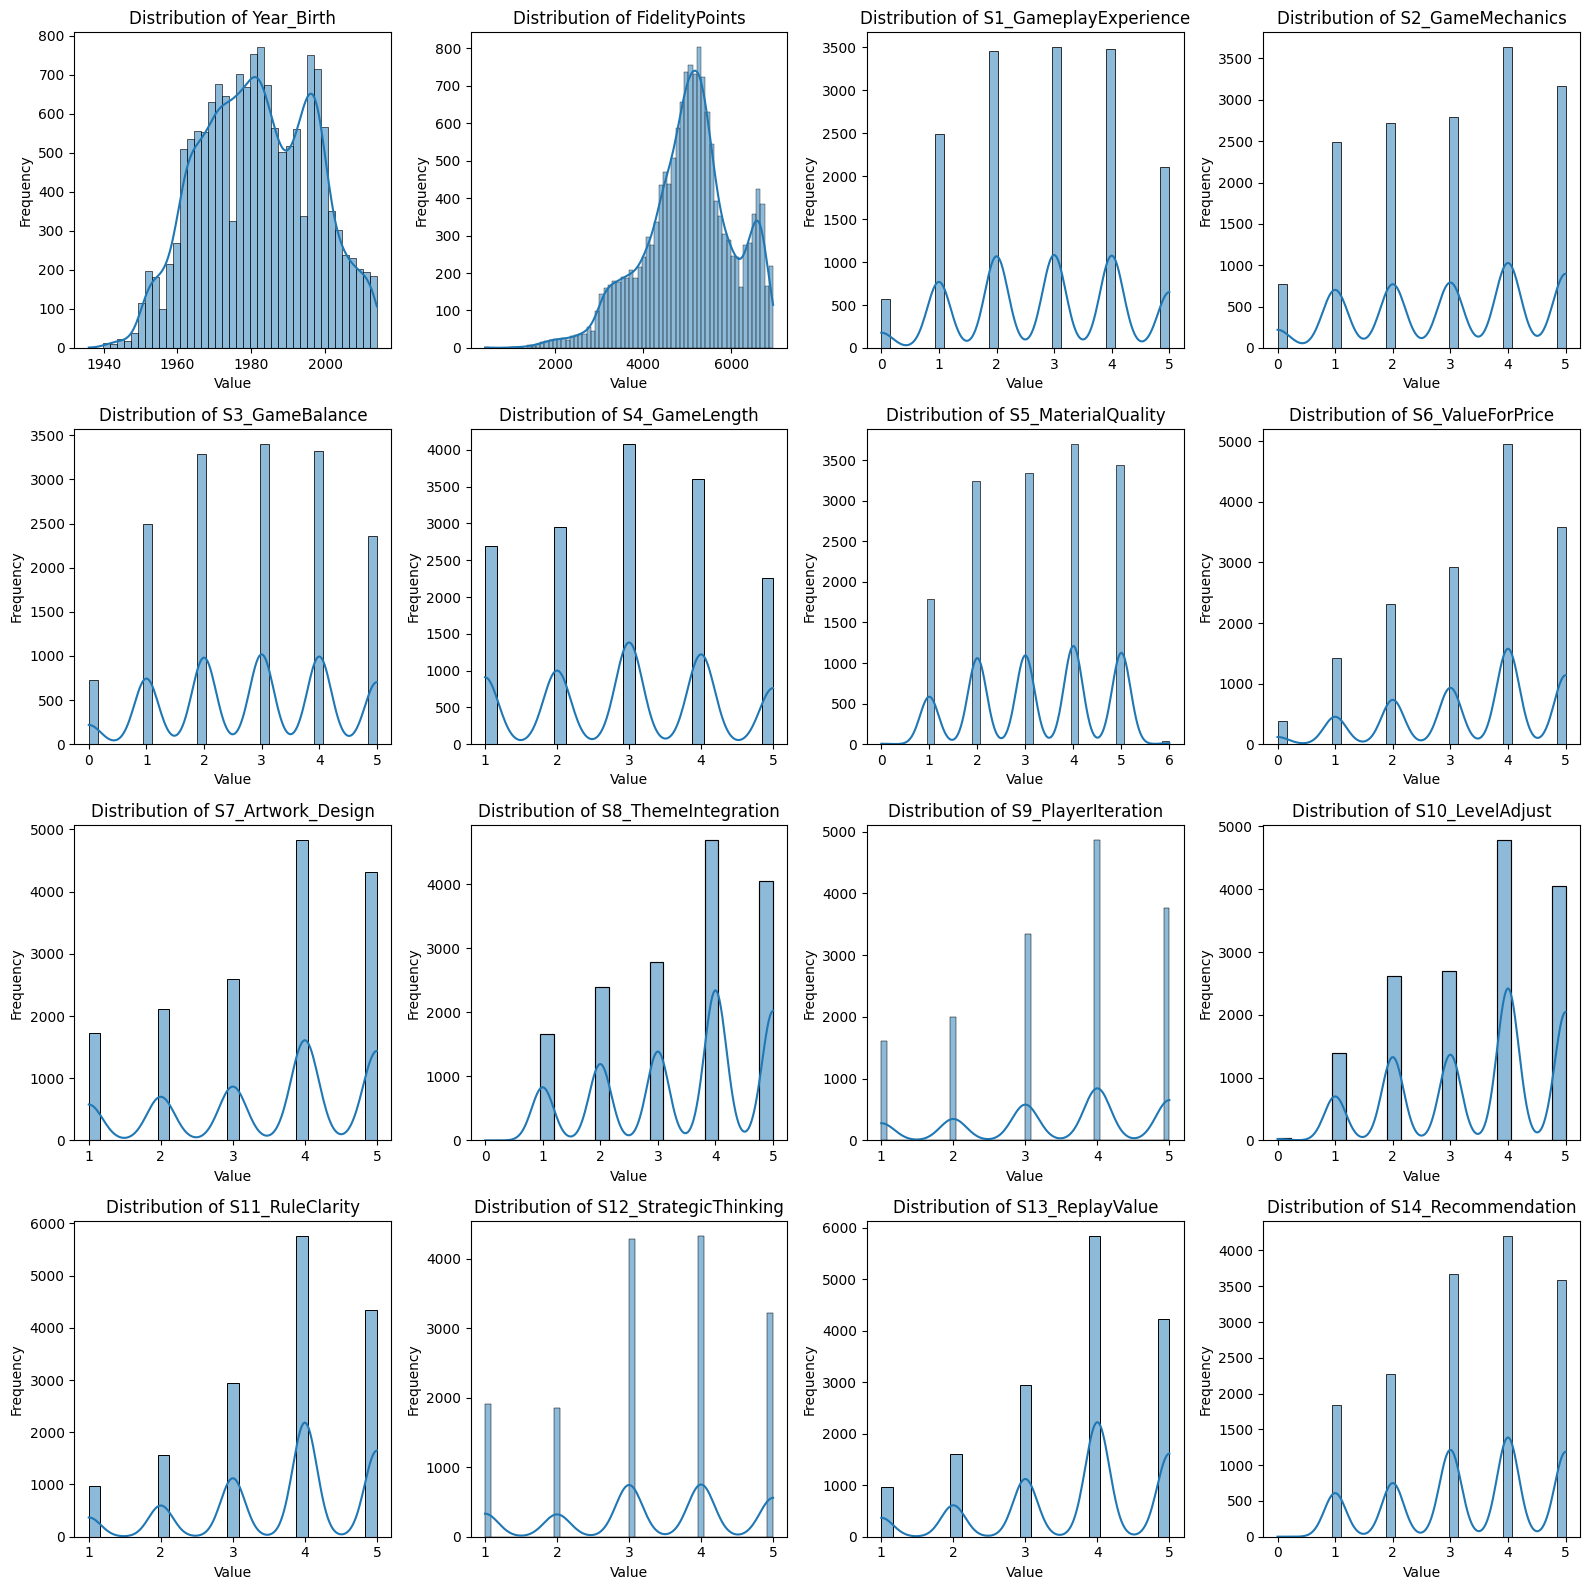

In [18]:
# Identify the length of the list to calculate the subplots
num_vars = len(numerical_columns)
rows = (num_vars + 1) // 4

fig, axes = plt.subplots(rows, 4, figsize=(16, 4*rows))

# Iterate over numerical variables and plot their distribution in the subplot grid
for i, num_var in enumerate(numerical_columns):
    row_idx = i // 4
    col_idx = i % 4
    sns.histplot(data[num_var], kde=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_xlabel('Value')
    axes[row_idx, col_idx].set_ylabel('Frequency')
    axes[row_idx, col_idx].set_title(f'Distribution of {num_var}')

# Remove empty subplot(s) if the number of numerical variables is odd
if num_vars % 2 != 0:
    fig.delaxes(axes[rows - 1, 1])

plt.tight_layout()
plt.show();

**Boxplots**

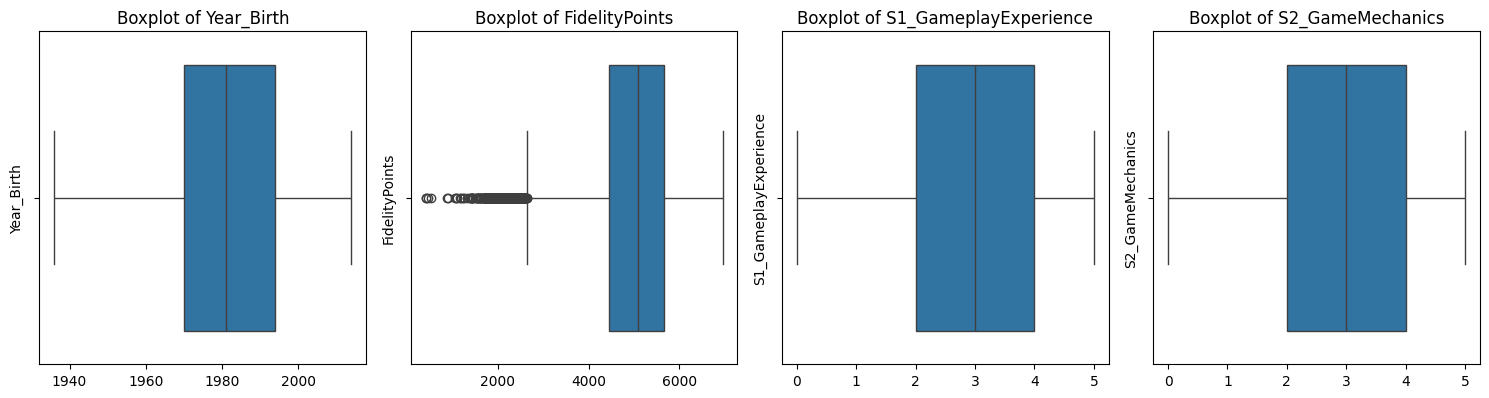

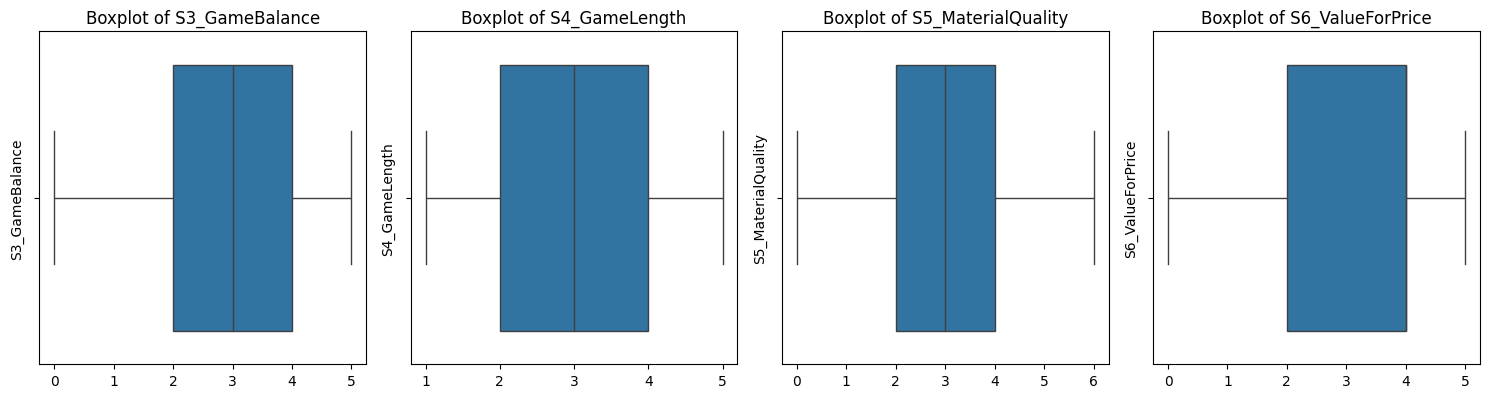

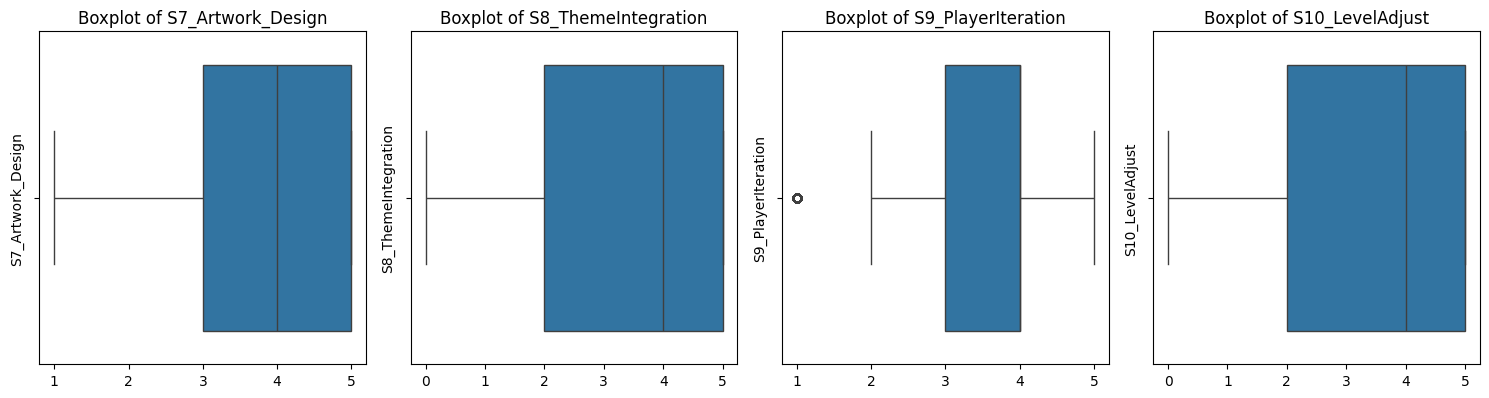

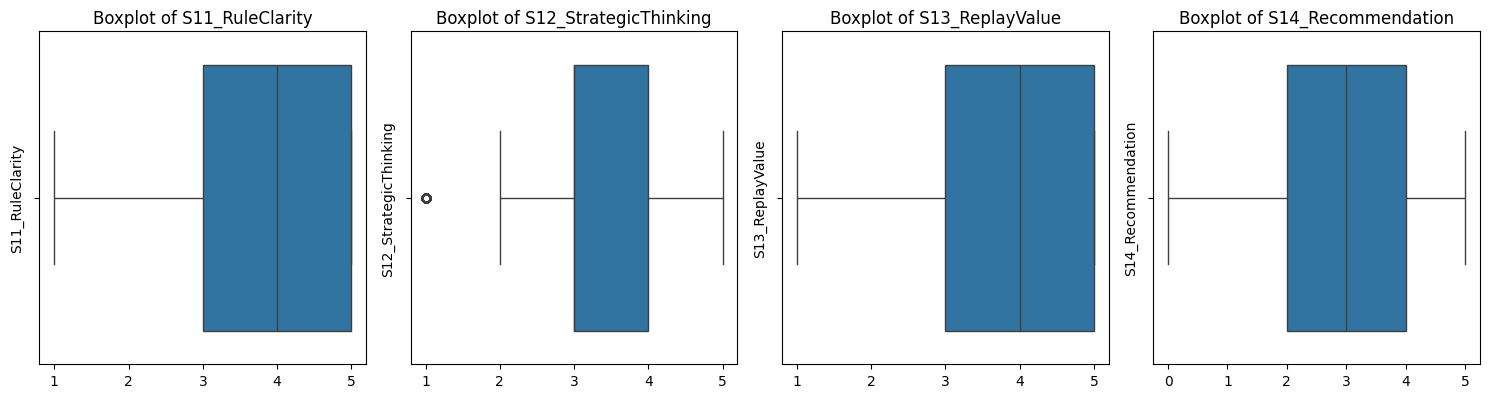

In [19]:
# Plot boxplots for each numerical variable
num_plots = len(numerical_columns)
num_plots_per_row = 4
num_rows = -(-num_plots // num_plots_per_row)

for i in range(0, num_plots, num_plots_per_row):
    plt.figure(figsize=(15, 15))
    for j, num_var in enumerate(numerical_columns[i:i+num_plots_per_row]):
        plt.subplot(num_rows, num_plots_per_row, j + 1)
        sns.boxplot(x=num_var, data=data)
        plt.title(f'Boxplot of {num_var}')
        plt.xlabel('')
        plt.ylabel(num_var)  # Set y-axis label to variable name
    plt.tight_layout()  # Adjust layout to prevent overlap of subplots
    plt.show()

From the box plots we can see that we have clear outliers in the variables `FidelityPoints`, `S9_PlayerIteration` and `S12_StrategicThinking`.

**Distribution Graphs**

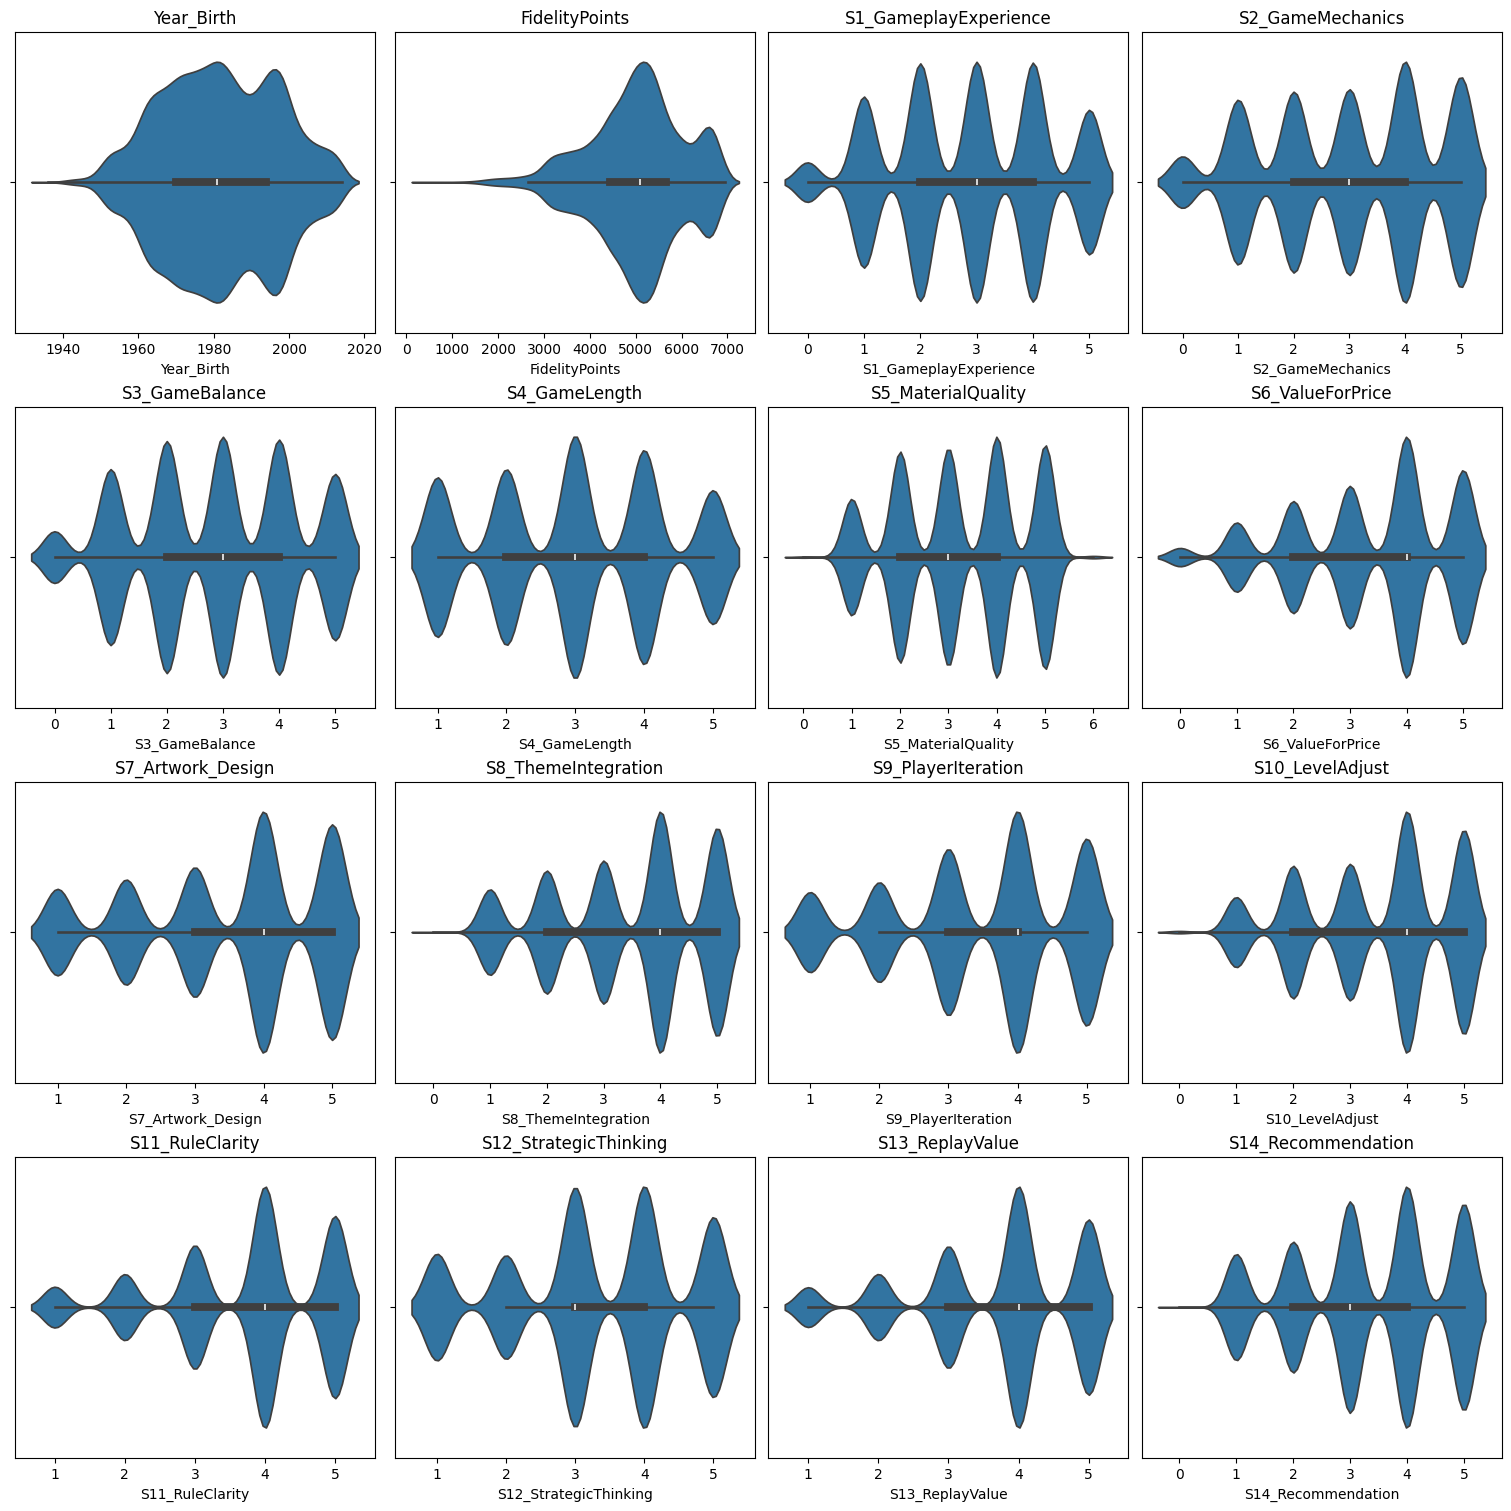

In [20]:
# Set up the figure and subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15), constrained_layout=True)

# Iterate through the numerical variables and create a violin plot for each
for ax, var in zip(axes.flatten(), data[numerical_columns]):
    sns.violinplot(x=var, data=data, ax=ax)
    ax.set_title(var)
    ax.set_xlabel(var)

# Adjust the layout and show the figure
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.935, wspace=None, hspace=0.4)
plt.show()

**Correlation Heatmap**

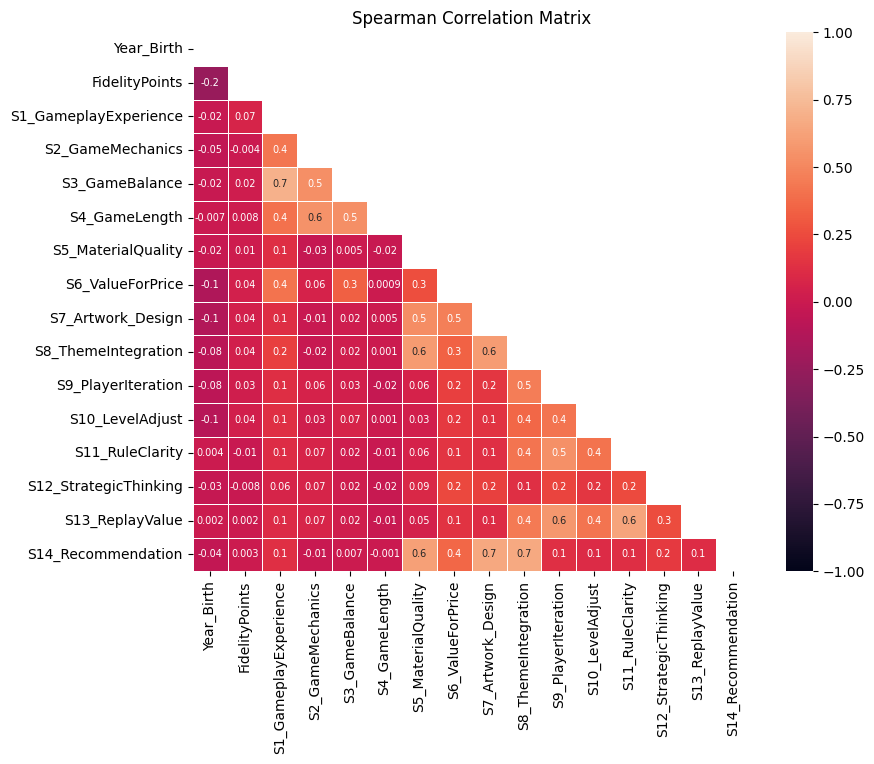

In [21]:
plt.figure(figsize=(9, 7))
corr = data[numerical_columns].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt = '.1g', linewidths=0.5, vmin=-1, vmax=1, mask=mask, annot_kws={"fontsize":7})
plt.title('Spearman Correlation Matrix')
plt.show()

blá, blá. blá

**Strip Plots**

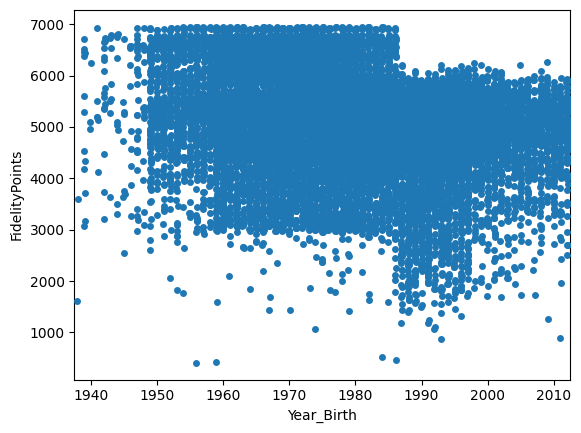

In [22]:
sns.stripplot(x='Year_Birth', y='FidelityPoints', data=data);
plt.xticks([2, 12, 22, 32, 42, 52, 62, 72], ['1940', '1950', '1960', '1970', '1980', '1990', '2000', '2010'])
plt.show()

#### 1.2.6 Missing Values

In [23]:
#Check how many missing values we have in the dataset
data.isna().sum()

Buy_product                  0
Name                         0
Newsletter_Subscription      0
Year_Birth                 195
Membership                   0
Preferred_Game_Genre         0
FidelityPoints               0
S1_GameplayExperience        0
S2_GameMechanics             0
S3_GameBalance               0
S4_GameLength                0
S5_MaterialQuality           0
S6_ValueForPrice             0
S7_Artwork_Design            0
S8_ThemeIntegration          0
S9_PlayerIteration           0
S10_LevelAdjust              0
S11_RuleClarity              0
S12_StrategicThinking        0
S13_ReplayValue              0
S14_Recommendation           0
dtype: int64

We have 195 missing values (NAs) in the variable `Year_Birth`.

## **2. Data Preprocessing**: Prepare the data for modeling

### 2.1 Remove Duplicates

In [24]:
#Drop the duplicates
print (f'Number of rows before removing duplicates: ', data.shape[0])
data.drop_duplicates(inplace = True)
print (f'Number of rows after removing duplicates: ', data.shape[0])

Number of rows before removing duplicates:  15589
Number of rows after removing duplicates:  15586


### 2.2 Handle Missing Values

In [25]:
# Remove rows with missing Year_Birth values
data.fillna({'Year_Birth': data['Year_Birth'].median()}, inplace=True)

Although we have the option to remove the rows with NA since the number of rows is reduced related to the dataset (about 1,3%), we decided instead to use the median and keep as much data as possible for the training.



In [26]:
#Check how many missing values we have in the dataset
data.isna().sum()

Buy_product                0
Name                       0
Newsletter_Subscription    0
Year_Birth                 0
Membership                 0
Preferred_Game_Genre       0
FidelityPoints             0
S1_GameplayExperience      0
S2_GameMechanics           0
S3_GameBalance             0
S4_GameLength              0
S5_MaterialQuality         0
S6_ValueForPrice           0
S7_Artwork_Design          0
S8_ThemeIntegration        0
S9_PlayerIteration         0
S10_LevelAdjust            0
S11_RuleClarity            0
S12_StrategicThinking      0
S13_ReplayValue            0
S14_Recommendation         0
dtype: int64

### 2.3 Correct the Variable Type

In [27]:
# Change the varialbe type of 'Year_Birth' from float to int
data['Year_Birth'] = data['Year_Birth'].astype(int)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15586 entries, 1 to 15589
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Buy_product              15586 non-null  int64 
 1   Name                     15586 non-null  object
 2   Newsletter_Subscription  15586 non-null  object
 3   Year_Birth               15586 non-null  int64 
 4   Membership               15586 non-null  object
 5   Preferred_Game_Genre     15586 non-null  object
 6   FidelityPoints           15586 non-null  int64 
 7   S1_GameplayExperience    15586 non-null  int64 
 8   S2_GameMechanics         15586 non-null  int64 
 9   S3_GameBalance           15586 non-null  int64 
 10  S4_GameLength            15586 non-null  int64 
 11  S5_MaterialQuality       15586 non-null  int64 
 12  S6_ValueForPrice         15586 non-null  int64 
 13  S7_Artwork_Design        15586 non-null  int64 
 14  S8_ThemeIntegration      15586 non-null  in

### 2.4 Data Incosistencies: variable `S5_MaterialQuality`

In point 2.2.1, we identified that 36 rows have a value in the `S5_MaterialQuality` variable euqal to 6, when the options should be one of {0, 1, 2, 3, 4, 5}. We could remove this 36 rows (it's only 0.2% of my dataset) but we believe that the value 6 was a mistake and should be replaced with the nearest valid value (e.g., 5).

In [29]:
# Replace anomalous S5_MaterialQuality values with 5
data.loc[data['S5_MaterialQuality'] == 6, 'S5_MaterialQuality'] = 5

In [30]:
#Get the main descriptive statistics for all the numeric variables
data.describe()

Buy_product    Year_Birth  FidelityPoints  S1_GameplayExperience  \
count  15586.000000  15586.000000    15586.000000           15586.000000   
mean       0.543757   1981.696779     5022.418581               2.841332   
std        0.498098     15.084697     1027.940126               1.388541   
min        0.000000   1936.000000      409.000000               0.000000   
25%        0.000000   1970.000000     4445.000000               2.000000   
50%        1.000000   1981.000000     5088.000000               3.000000   
75%        1.000000   1994.000000     5648.750000               4.000000   
max        1.000000   2014.000000     6950.000000               5.000000   

       S2_GameMechanics  S3_GameBalance  S4_GameLength  S5_MaterialQuality  \
count      15586.000000    15586.000000   15586.000000        15586.000000   
mean           2.997049        2.844412       2.985821            3.242654   
std            1.519035        1.436937       1.299438            1.323131   
min            0.000000        0.000000       1.000000            0.000000   
25%            2.000000        2.000000       2.000000            2.000000   
50%            3.000000        3.000000       3.000000            3.000000   
75%            4.000000        4.000000       4.000000            4.000000   
max            5.000000        5.000000       5.000000            5.000000   

       S6_ValueForPrice  S7_Artwork_Design  S8_ThemeIntegration  \
count      15586.000000       15586.000000         15586.000000   
mean           3.374631           3.506288             3.454190   
std            1.352419           1.319625             1.310401   
min            0.000000           1.000000             0.000000   
25%            2.000000           3.000000             2.000000   
50%            4.000000           4.000000             4.000000   
75%            4.000000           5.000000             5.000000   
max            5.000000           5.000000             5.000000   

       S9_PlayerIteration  S10_LevelAdjust  S11_RuleClarity  \
count        15586.000000     15586.000000     15586.000000   
mean             3.459579         3.470871         3.700500   
std              1.268180         1.293782         1.158693   
min              1.000000         0.000000         1.000000   
25%              3.000000         2.000000         3.000000   
50%              4.000000         4.000000         4.000000   
75%              4.000000         5.000000         5.000000   
max              5.000000         5.000000         5.000000   

       S12_StrategicThinking  S13_ReplayValue  S14_Recommendation  
count           15586.000000     15586.000000        15586.000000  
mean                3.327409         3.692288            3.347427  
std                 1.266944         1.154484            1.300371  
min                 1.000000         1.000000            0.000000  
25%                 3.000000         3.000000            2.000000  
50%                 3.000000         4.000000            3.000000  
75%                 4.000000         5.000000            4.000000  
max                 5.000000         5.000000            5.000000

### 2.5 Data Incosistencies: variable `Newsletter_Subscription`

In the Basic Exploration (point 2.1) we identified that when customers has the `Newsletter_Subscription` active, we have records of both `yes` and `y`. We are going to put all those rows with the value `yes`.

In [31]:
#Replace 'y' for 'yes' in the 'Newsletter_Subscription' variable
data['Newsletter_Subscription'] = data['Newsletter_Subscription'].replace('y', 'yes')

In [32]:
# Statistical Analysis for Categorical Features
data[categorical_columns].describe()

Name Newsletter_Subscription Membership  \
count               15586                   15586      15586   
unique              14227                       2          2   
top     Mr. Michael Smith                     yes    Premium   
freq                    9                   12712      10754   

       Preferred_Game_Genre  
count                 15586  
unique                    3  
top                Strategy  
freq                   7442

We can now see that we have only 2 unique values for the `Newsletter_Subscription` variable.

### 2.6  Remove Outliers

In [33]:
#Checkpoint
data_bkp = data.copy()

In [34]:
#Remove outliers in FidelityPoints
data = data[~(data['FidelityPoints'] < 1000)]

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15580 entries, 1 to 15589
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Buy_product              15580 non-null  int64 
 1   Name                     15580 non-null  object
 2   Newsletter_Subscription  15580 non-null  object
 3   Year_Birth               15580 non-null  int64 
 4   Membership               15580 non-null  object
 5   Preferred_Game_Genre     15580 non-null  object
 6   FidelityPoints           15580 non-null  int64 
 7   S1_GameplayExperience    15580 non-null  int64 
 8   S2_GameMechanics         15580 non-null  int64 
 9   S3_GameBalance           15580 non-null  int64 
 10  S4_GameLength            15580 non-null  int64 
 11  S5_MaterialQuality       15580 non-null  int64 
 12  S6_ValueForPrice         15580 non-null  int64 
 13  S7_Artwork_Design        15580 non-null  int64 
 14  S8_ThemeIntegration      15580 non-null  in

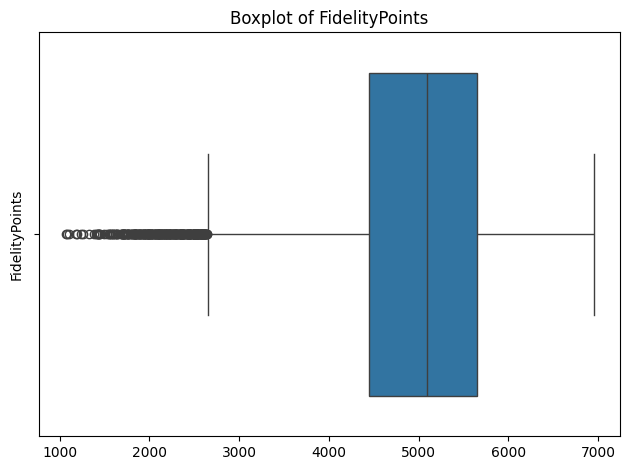

In [36]:
num_var='FidelityPoints'
sns.boxplot(x=num_var, data=data)
plt.title(f'Boxplot of {num_var}')
plt.xlabel('')
plt.ylabel(num_var)  # Set y-axis label to variable name
plt.tight_layout()  # Adjust layout to prevent overlap of subplots
plt.show()

In [37]:
data['S9_PlayerIteration'].value_counts()

S9_PlayerIteration
4    4863
5    3761
3    3344
2    2003
1    1609
Name: count, dtype: int64

In [38]:
data['S12_StrategicThinking'].value_counts()

S12_StrategicThinking
4    4322
3    4281
5    3221
1    1906
2    1850
Name: count, dtype: int64

Looking at the boxplots it seems that we have ouliers in both the `S9_PlayerIteration` and `S12_StrategicThinking` variables. However, looking at the distribution we can see that the values that are idenified as outliers don't occur with very low frequency compared to others. In this way, they cannot be considered outliers.

### 2.7 Feature Engineering

#### 2.7.1 Add `Male` Variable

Since we have all the names of the customers starting either from 'Mr' or 'Ms', we can create a new variable, that we named `Male`, to identify the gender of the customer. It will be binary and have 1 for male and 0 for female.

In [39]:
data['Male'] = data['Name'].apply(lambda x: 1 if x.startswith('Mr') else 0)
data['Male'].value_counts()

Male
0    7979
1    7601
Name: count, dtype: int64

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15580 entries, 1 to 15589
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Buy_product              15580 non-null  int64 
 1   Name                     15580 non-null  object
 2   Newsletter_Subscription  15580 non-null  object
 3   Year_Birth               15580 non-null  int64 
 4   Membership               15580 non-null  object
 5   Preferred_Game_Genre     15580 non-null  object
 6   FidelityPoints           15580 non-null  int64 
 7   S1_GameplayExperience    15580 non-null  int64 
 8   S2_GameMechanics         15580 non-null  int64 
 9   S3_GameBalance           15580 non-null  int64 
 10  S4_GameLength            15580 non-null  int64 
 11  S5_MaterialQuality       15580 non-null  int64 
 12  S6_ValueForPrice         15580 non-null  int64 
 13  S7_Artwork_Design        15580 non-null  int64 
 14  S8_ThemeIntegration      15580 non-null  in

#### 2.7.2 Add `Age`Variable

In [41]:
from datetime import date
data['Age'] = date.today().year - data['Year_Birth']
data['Age'].value_counts().sort_index()

Age
10     84
11    100
12     98
13     96
14    106
     ... 
80     16
81      6
82      3
83     13
88      2
Name: count, Length: 75, dtype: int64

#### 2.7.3 Add `Global_Satisfation` Variable

In [42]:
score_columns = [
    'S1_GameplayExperience', 'S2_GameMechanics', 'S3_GameBalance', 'S4_GameLength',
    'S5_MaterialQuality', 'S6_ValueForPrice', 'S7_Artwork_Design', 'S8_ThemeIntegration',
    'S9_PlayerIteration', 'S10_LevelAdjust', 'S11_RuleClarity', 'S12_StrategicThinking',
    'S13_ReplayValue', 'S14_Recommendation'
]
data['Global_Satisfation'] = data[score_columns].mean(axis=1)
data.head()

Buy_product                    Name Newsletter_Subscription  \
Cust_ID                                                                
1                  0       Ms. Nicole Clarke                     yes   
2                  1         Mr. Jesse Scott                     yes   
3                  0  Mr. Christopher Carter                     yes   
4                  1     Ms. Jennifer Morgan                     yes   
5                  1       Mr. Michael White                     yes   

         Year_Birth   Membership Preferred_Game_Genre  FidelityPoints  \
Cust_ID                                                                 
1              1974      Premium             Strategy            4907   
2              1965      Premium             Strategy            6724   
3              1973      Premium             Strategy            4365   
4              1993  Non-Premium                Party            3849   
5              1989      Premium             Strategy            5376   

         S1_GameplayExperience  S2_GameMechanics  S3_GameBalance  ...  \
Cust_ID                                                           ...   
1                            3                 4               1  ...   
2                            1                 1               1  ...   
3                            3                 3               3  ...   
4                            1                 1               1  ...   
5                            2                 2               3  ...   

         S8_ThemeIntegration  S9_PlayerIteration  S10_LevelAdjust  \
Cust_ID                                                             
1                          3                   3                3   
2                          5                   5                5   
3                          3                   3                2   
4                          4                   4                4   
5                          5                   5                3   

         S11_RuleClarity  S12_StrategicThinking  S13_ReplayValue  \
Cust_ID                                                            
1                      3                      4                3   
2                      5                      1                5   
3                      3                      2                3   
4                      4                      4                4   
5                      4                      1                3   

         S14_Recommendation  Male  Age  Global_Satisfation  
Cust_ID                                                     
1                         4     0   50            3.285714  
2                         2     1   59            3.142857  
3                         1     1   51            2.714286  
4                         3     0   31            3.142857  
5                         5     1   35            3.571429  

[5 rows x 24 columns]

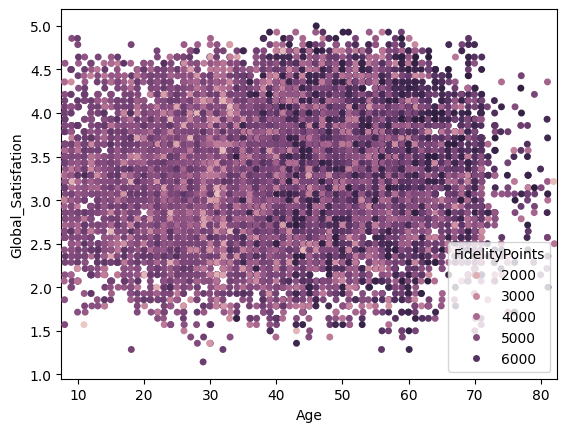

In [43]:
sns.stripplot(x='Age', y='Global_Satisfation', data=data, hue='FidelityPoints');
plt.xticks([2, 12, 22, 32, 42, 52, 62, 72], ['10', '20', '30', '40', '50', '60', '70', '80'])
plt.show()

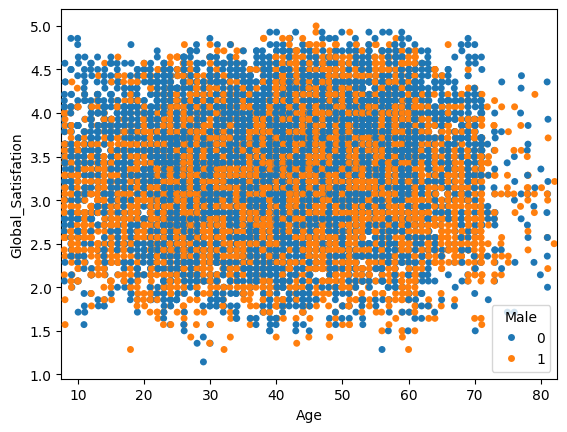

In [44]:
sns.stripplot(x='Age', y='Global_Satisfation', data=data, hue='Male');
plt.xticks([2, 12, 22, 32, 42, 52, 62, 72], ['10', '20', '30', '40', '50', '60', '70', '80'])
plt.show()

In [45]:
numerical_columns.remove('Year_Birth')
numerical_columns.append('Male')
numerical_columns.append('Age')
numerical_columns.append('Global_Satisfation')


In [46]:
numerical_columns

['FidelityPoints',
 'S1_GameplayExperience',
 'S2_GameMechanics',
 'S3_GameBalance',
 'S4_GameLength',
 'S5_MaterialQuality',
 'S6_ValueForPrice',
 'S7_Artwork_Design',
 'S8_ThemeIntegration',
 'S9_PlayerIteration',
 'S10_LevelAdjust',
 'S11_RuleClarity',
 'S12_StrategicThinking',
 'S13_ReplayValue',
 'S14_Recommendation',
 'Male',
 'Age',
 'Global_Satisfation']

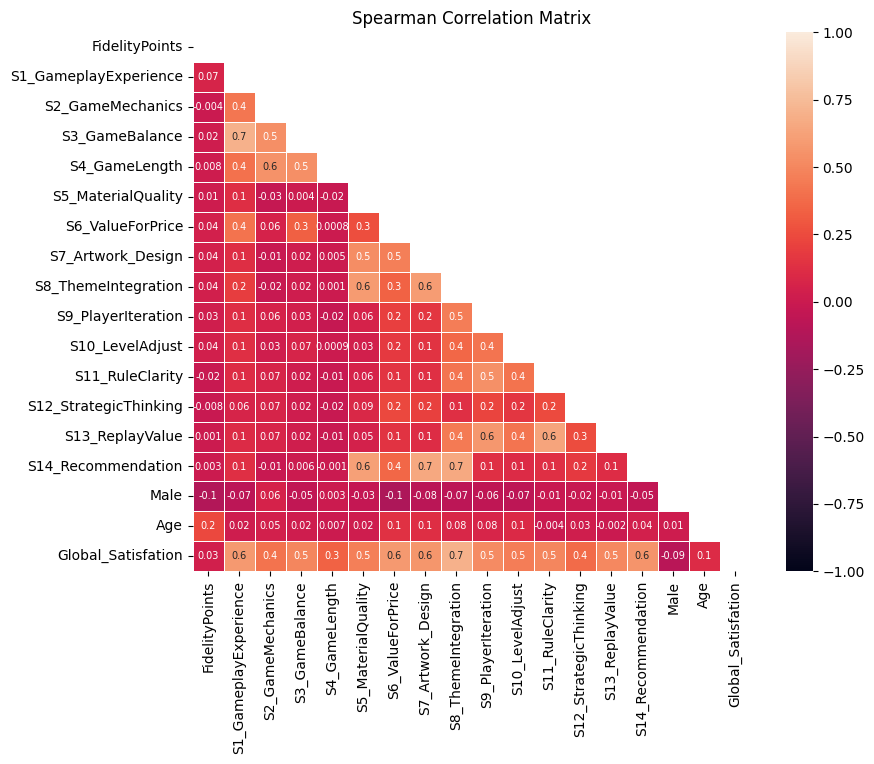

In [47]:
plt.figure(figsize=(9, 7))
corr = data[numerical_columns].corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt = '.1g', linewidths=0.5, vmin=-1, vmax=1, mask=mask, annot_kws={"fontsize":7})
plt.title('Spearman Correlation Matrix')
plt.show()

We can see that there is no correlation whatsoever of this variable to any of the others in the dataset so it seems that it will probably be a vraible to remove in the next phase.

#### 2.7.4 Binary Encoding

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15580 entries, 1 to 15589
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Buy_product              15580 non-null  int64  
 1   Name                     15580 non-null  object 
 2   Newsletter_Subscription  15580 non-null  object 
 3   Year_Birth               15580 non-null  int64  
 4   Membership               15580 non-null  object 
 5   Preferred_Game_Genre     15580 non-null  object 
 6   FidelityPoints           15580 non-null  int64  
 7   S1_GameplayExperience    15580 non-null  int64  
 8   S2_GameMechanics         15580 non-null  int64  
 9   S3_GameBalance           15580 non-null  int64  
 10  S4_GameLength            15580 non-null  int64  
 11  S5_MaterialQuality       15580 non-null  int64  
 12  S6_ValueForPrice         15580 non-null  int64  
 13  S7_Artwork_Design        15580 non-null  int64  
 14  S8_ThemeIntegration      15

In [49]:
one_hot_encoded_data = []
one_hot_encoded_data = pd.get_dummies(data, columns = ['Membership', 'Newsletter_Subscription'])
print(one_hot_encoded_data)

         Buy_product                    Name  Year_Birth Preferred_Game_Genre  \
Cust_ID                                                                         
1                  0       Ms. Nicole Clarke        1974             Strategy   
2                  1         Mr. Jesse Scott        1965             Strategy   
3                  0  Mr. Christopher Carter        1973             Strategy   
4                  1     Ms. Jennifer Morgan        1993                Party   
5                  1       Mr. Michael White        1989             Strategy   
...              ...                     ...         ...                  ...   
15585              0       Ms. Wendy Roberts        1988                Party   
15586              0         Ms. Sonya Smith        2000                Party   
15587              1      Mr. Maxwell Wright        1964             Strategy   
15588              1       Mr. Gregory Moran        1992                Party   
15589              0       M

In [50]:
one_hot_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15580 entries, 1 to 15589
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Buy_product                  15580 non-null  int64  
 1   Name                         15580 non-null  object 
 2   Year_Birth                   15580 non-null  int64  
 3   Preferred_Game_Genre         15580 non-null  object 
 4   FidelityPoints               15580 non-null  int64  
 5   S1_GameplayExperience        15580 non-null  int64  
 6   S2_GameMechanics             15580 non-null  int64  
 7   S3_GameBalance               15580 non-null  int64  
 8   S4_GameLength                15580 non-null  int64  
 9   S5_MaterialQuality           15580 non-null  int64  
 10  S6_ValueForPrice             15580 non-null  int64  
 11  S7_Artwork_Design            15580 non-null  int64  
 12  S8_ThemeIntegration          15580 non-null  int64  
 13  S9_PlayerIteration   

In [51]:
# Remove one of the new columns created for the binary variables 'Membership' and 'Newsletter_Subscription'
one_hot_encoded_data.drop(['Membership_Non-Premium', 'Newsletter_Subscription_no'], axis = 1, inplace = True)

# Rename the variable from 'Newsletter_Subscription_yes' to 'Newsletter_Subscription'
one_hot_encoded_data.rename(columns={'Newsletter_Subscription_yes': 'Newsletter_Subscription'}, inplace=True)

In [52]:
one_hot_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15580 entries, 1 to 15589
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Buy_product              15580 non-null  int64  
 1   Name                     15580 non-null  object 
 2   Year_Birth               15580 non-null  int64  
 3   Preferred_Game_Genre     15580 non-null  object 
 4   FidelityPoints           15580 non-null  int64  
 5   S1_GameplayExperience    15580 non-null  int64  
 6   S2_GameMechanics         15580 non-null  int64  
 7   S3_GameBalance           15580 non-null  int64  
 8   S4_GameLength            15580 non-null  int64  
 9   S5_MaterialQuality       15580 non-null  int64  
 10  S6_ValueForPrice         15580 non-null  int64  
 11  S7_Artwork_Design        15580 non-null  int64  
 12  S8_ThemeIntegration      15580 non-null  int64  
 13  S9_PlayerIteration       15580 non-null  int64  
 14  S10_LevelAdjust          15

In [53]:
one_hot_encoded_data=one_hot_encoded_data.drop('Name', axis = 1)
one_hot_encoded_data=one_hot_encoded_data.drop('Year_Birth', axis = 1)

In [54]:
one_hot_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15580 entries, 1 to 15589
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Buy_product              15580 non-null  int64  
 1   Preferred_Game_Genre     15580 non-null  object 
 2   FidelityPoints           15580 non-null  int64  
 3   S1_GameplayExperience    15580 non-null  int64  
 4   S2_GameMechanics         15580 non-null  int64  
 5   S3_GameBalance           15580 non-null  int64  
 6   S4_GameLength            15580 non-null  int64  
 7   S5_MaterialQuality       15580 non-null  int64  
 8   S6_ValueForPrice         15580 non-null  int64  
 9   S7_Artwork_Design        15580 non-null  int64  
 10  S8_ThemeIntegration      15580 non-null  int64  
 11  S9_PlayerIteration       15580 non-null  int64  
 12  S10_LevelAdjust          15580 non-null  int64  
 13  S11_RuleClarity          15580 non-null  int64  
 14  S12_StrategicThinking    15

# 2.8 Feature Selection: Select the most relevant features for the model

In [55]:
from sklearn.model_selection import StratifiedKFold

In [56]:
skf = StratifiedKFold(n_splits = 10, random_state = 99, shuffle = True)

In [57]:
X = one_hot_encoded_data.drop('Buy_product', axis = 1)
y = one_hot_encoded_data['Buy_product'].copy()

In [58]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15580 entries, 1 to 15589
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Preferred_Game_Genre     15580 non-null  object 
 1   FidelityPoints           15580 non-null  int64  
 2   S1_GameplayExperience    15580 non-null  int64  
 3   S2_GameMechanics         15580 non-null  int64  
 4   S3_GameBalance           15580 non-null  int64  
 5   S4_GameLength            15580 non-null  int64  
 6   S5_MaterialQuality       15580 non-null  int64  
 7   S6_ValueForPrice         15580 non-null  int64  
 8   S7_Artwork_Design        15580 non-null  int64  
 9   S8_ThemeIntegration      15580 non-null  int64  
 10  S9_PlayerIteration       15580 non-null  int64  
 11  S10_LevelAdjust          15580 non-null  int64  
 12  S11_RuleClarity          15580 non-null  int64  
 13  S12_StrategicThinking    15580 non-null  int64  
 14  S13_ReplayValue          15

### 2.8.1 Categorical Features

#### 2.8.1.1 Chi-Square (Filter Method) - For categorical data

In [59]:
def apply_chisquare(X,y,var,alpha=0.05):
    dfObserved = pd.crosstab(y,X)
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [60]:
def select_best_cat_features(X,y):
    count = 1

    ############################################## APPLY SKF ######################################################
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        #################################### SELECT FEATURES WITH CHI-SQUARE #######################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using chi-square
        X_train_cat = X_train[['Preferred_Game_Genre','Male','Membership_Premium','Newsletter_Subscription']].copy()
        for var in X_train_cat:
            apply_chisquare(X_train_cat[var],y_train, var)

        count+=1

In [61]:
select_best_cat_features(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
Preferred_Game_Genre is IMPORTANT for Prediction
Male is IMPORTANT for Prediction
Membership_Premium is IMPORTANT for Prediction
Newsletter_Subscription is IMPORTANT for Prediction
_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________
Preferred_Game_Genre is IMPORTANT for Prediction
Male is IMPORTANT for Prediction
Membership_Premium is IMPORTANT for Prediction
Newsletter_Subscription is IMPORTANT for Prediction
__________________________________________________________________________________

The conclusion is that all the 4 variables are important and should be kept.

#### 2.8.1.2 ANOVA (Filter Method) - For categorical data

In [64]:
from sklearn.feature_selection import f_classif


def filter_fs_df(X, y, skf):
    '''
    Returns a dataframe with the Kendall's Correlation, ANOVA and Chi-Square applied to the input data

    Args:
        X (pandas.dataframe) - Variables
        y (pandas.dataframe) - Target
        skf (object) - StratifiedKFold instance

    Returns:
        pandas.dataframe
    '''
    df = pd.DataFrame()
    df['Features'] = X.columns

    kendall_feat_count = {}  # Dictionary to store counts for Kendall's Correlation
    anova_feat_count = {}  # Dictionary to store counts for ANOVA
    chi_feat_count = {}  # Dictionary to store counts for Chi-Square

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]


        # Select numerical and categorical features
        X_train_num = X_train.select_dtypes(include=[np.number])
        X_train_cat = X_train.select_dtypes(include=['object', 'category'])

        # Apply Kendall's correlation for numerical features
        for col in X_train_num:
            if abs(stats.kendalltau(X_train_num[col], y_train)[0]) > .5:
                if col in kendall_feat_count:
                    kendall_feat_count[col] += 1
                else:
                    kendall_feat_count[col] = 1

        # Apply ANOVA for numerical features
        for col in X_train_num:
            fvalue, pvalue = f_classif(X_train_num[[col]], y_train)
            if pvalue[0] < 0.05:
                if col in anova_feat_count:
                    anova_feat_count[col] += 1
                else:
                    anova_feat_count[col] = 1

        # Apply Chi-Square for categorical features
        for col in X_train_cat:
            chi_check = pd.crosstab(y_train, X_train_cat[col])
            chi2, p, dof, expected = chi2_contingency(chi_check.values)
            if p < .05:
                if col in chi_feat_count:
                    chi_feat_count[col] += 1
                else:
                    chi_feat_count[col] = 1

    df['Kendall_Significant_Count'] = df['Features'].apply(lambda x: kendall_feat_count[x] if x in kendall_feat_count else 0)
    df['Filter_Kendall'] = df['Kendall_Significant_Count'].apply(lambda x: 'Keep' if x > 3 else 'Discard')
    df.loc[df['Features'].apply(lambda x: X[x].dtypes not in [np.number, np.float64, np.int64]), 'Filter_Kendall'] = '-'

    df['ANOVA_Significant_Count'] = df['Features'].apply(lambda x: anova_feat_count[x] if x in anova_feat_count else 0)
    df['Filter_ANOVA'] = df['ANOVA_Significant_Count'].apply(lambda x: 'Keep' if x > 3 else 'Discard')
    df.loc[df['Features'].apply(lambda x: X[x].dtypes not in [np.number, np.float64, np.int64]), 'Filter_ANOVA'] = '-'

    df['CHI2_Significant_Count'] = df['Features'].apply(lambda x: chi_feat_count[x] if x in chi_feat_count else 0)
    df['Filter_CHI2'] = df['CHI2_Significant_Count'].apply(lambda x: 'Keep' if x > 3 else 'Discard')
    df.loc[df['Features'].apply(lambda x: X[x].dtypes in [np.number, np.float64, np.int64]), 'Filter_CHI2'] = '-'

    return df

filtered = filter_fs_df(X, y, skf)
filtered.style

### 2.8.2 Numerical Features

In [65]:
numerical_columns = X.select_dtypes(include=[np.number]).columns

#### 2.8.2.1 Variance (Filter Method) - For continuous, ordinal and binary data

In [66]:
def apply_variance(X_train, var):
  print(var + ':' + str(X_train.var()))

In [67]:
def select_features_variance(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ######################################### SELECT FEATURES #################################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using variance
        for var in numerical_columns:
          apply_variance(X_train[var], var)

        count+=1

In [68]:
select_features_variance(X,y)

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________
FidelityPoints:1049776.403144331
S1_GameplayExperience:1.9237159298646016
S2_GameMechanics:2.3028233288350175
S3_GameBalance:2.0584697510044405
S4_GameLength:1.6908840185327894
S5_MaterialQuality:1.7472588568092298
S6_ValueForPrice:1.8305640750317764
S7_Artwork_Design:1.7427401900999588
S8_ThemeIntegration:1.7167167774328278
S9_PlayerIteration:1.602517286889317
S10_LevelAdjust:1.6750195173039086
S11_RuleClarity:1.339212573034818
S12_StrategicThinking:1.6054393662679565
S13_ReplayValue:1.329687015821806
S14_Recommendation:1.6936374072467109
Male:0.24983227320927448
Age:226.57328000297372
Global_Satisfation:0.4469769475828885
__________________________________________________________________________________________

The conclusion is that there are no constant features, so no variables will be removed.

#### 2.8.2.2 Spearman Correlation (Filter Method) - For continuous and ordinal data

In [69]:
def cor_heatmap(cor):
    plt.figure(figsize=(9,6))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

Remove the binary variables: `Male`, `Membership_Premium` and `Newsletter_Subscription`.


In [70]:
def apply_correlation(X_train):
    correlation_data = X_train.drop(['Male', 'Membership_Premium', 'Newsletter_Subscription'], axis = 1).copy()
    matrix = correlation_data.corr(method = 'spearman', numeric_only = True)
    cor_heatmap(matrix)

In [71]:
def redundant_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ######################################### SELECT FEATURES #################################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # check which features to use using spearman correlation
        apply_correlation(X_train)

        count+=1

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________


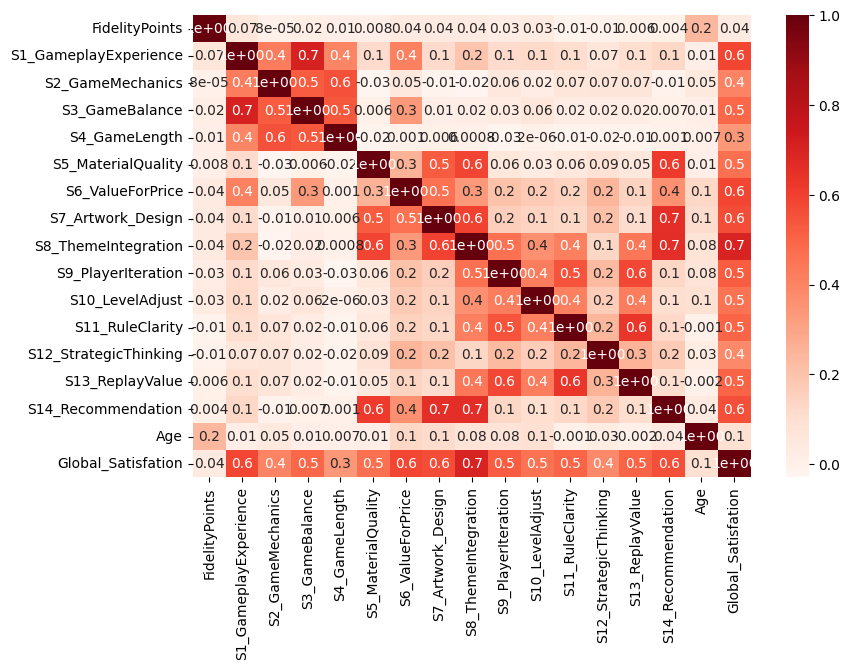

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________


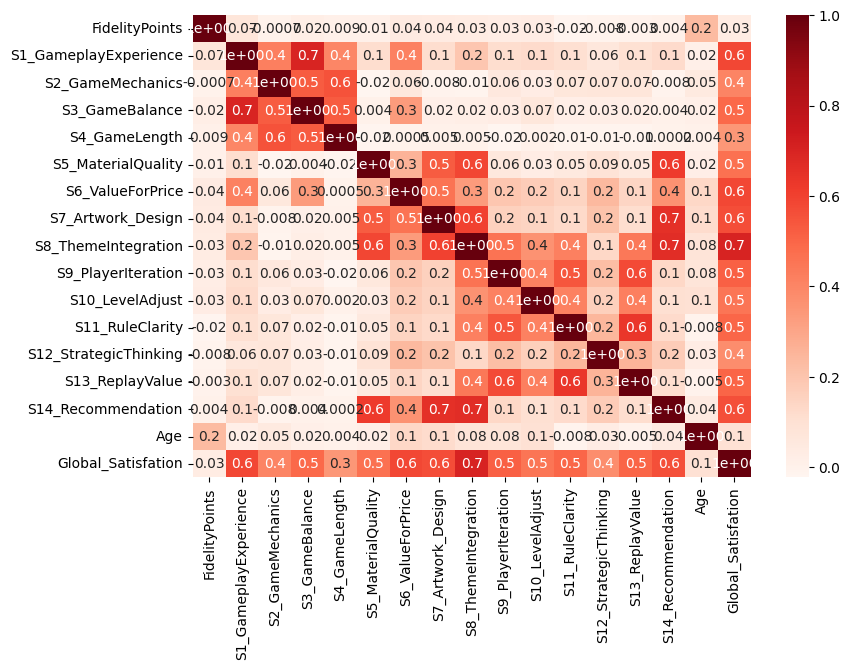

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________


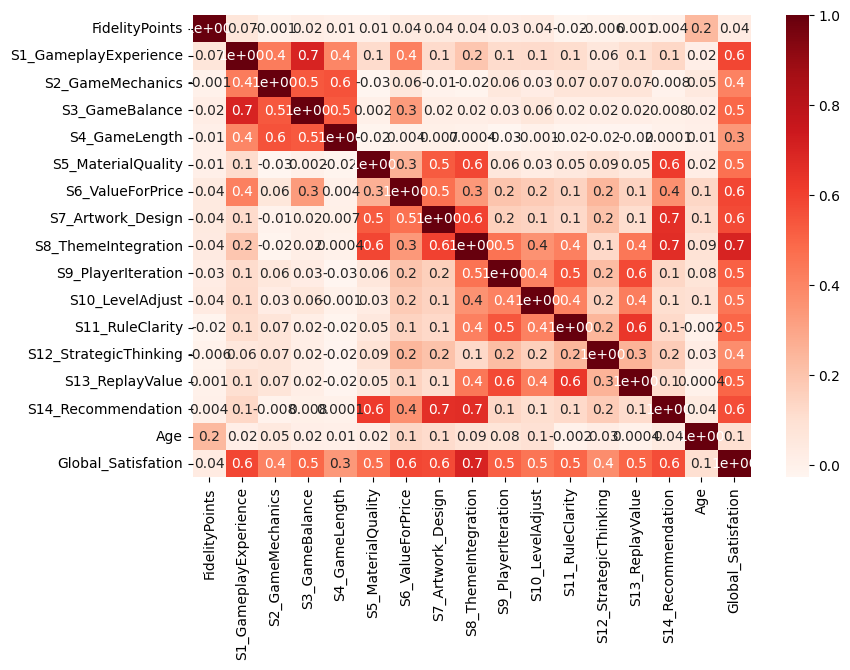

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________


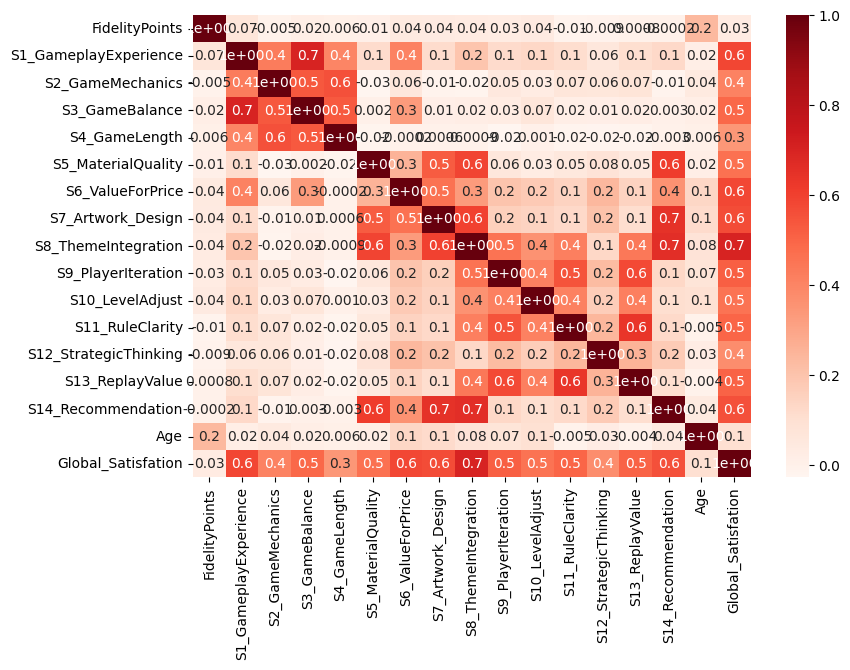

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________


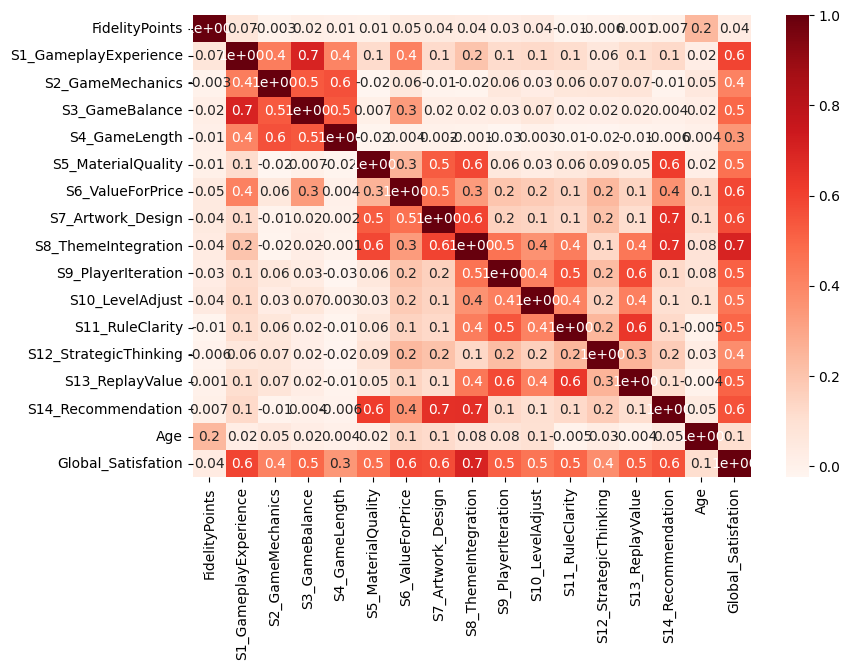

_________________________________________________________________________________________________

                                     SPLIT 6                                    
_________________________________________________________________________________________________


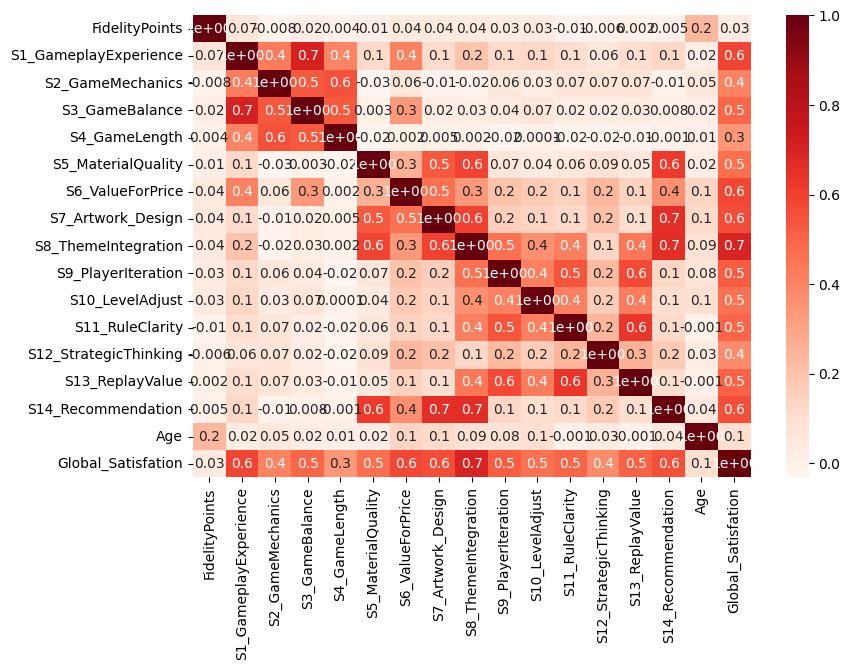

_________________________________________________________________________________________________

                                     SPLIT 7                                    
_________________________________________________________________________________________________


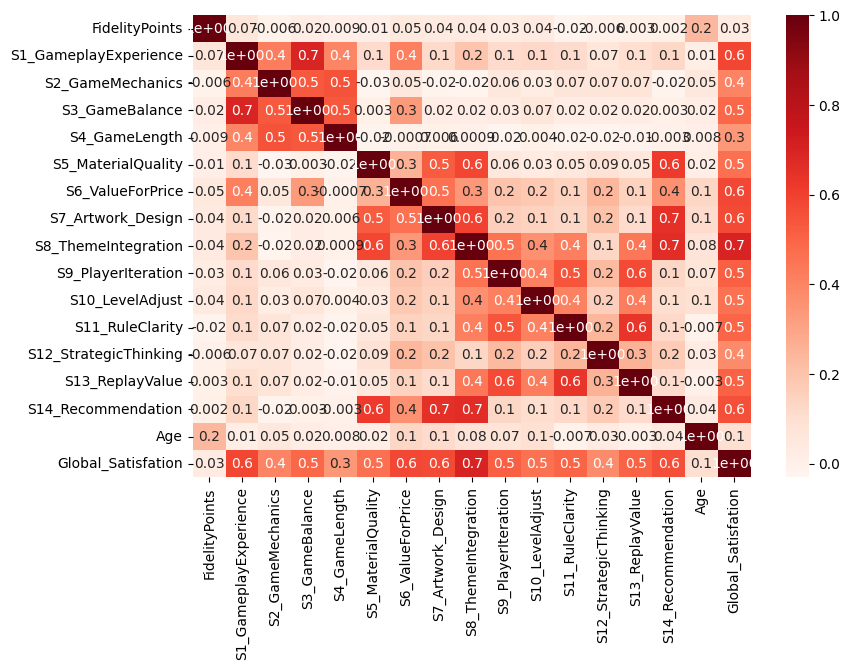

_________________________________________________________________________________________________

                                     SPLIT 8                                    
_________________________________________________________________________________________________


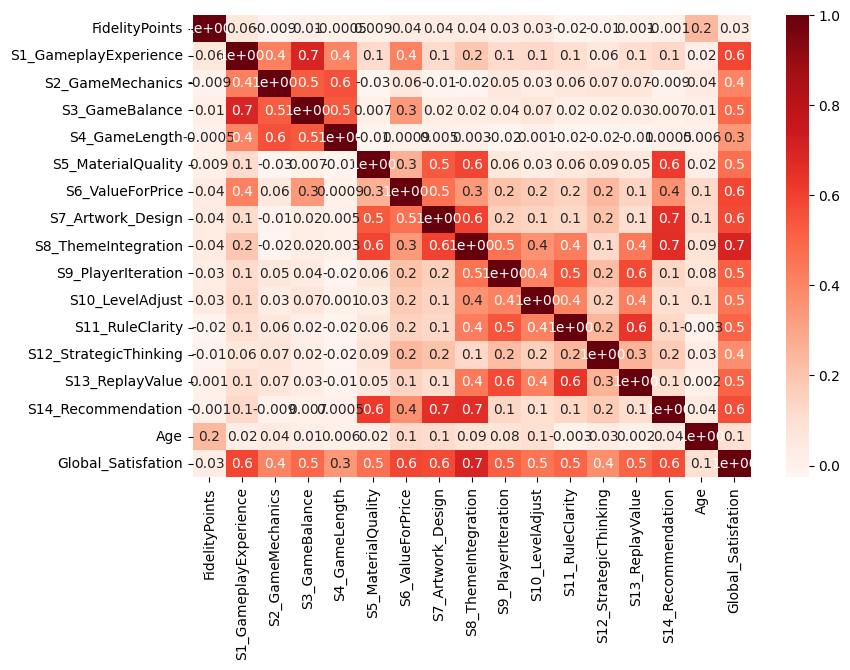

_________________________________________________________________________________________________

                                     SPLIT 9                                    
_________________________________________________________________________________________________


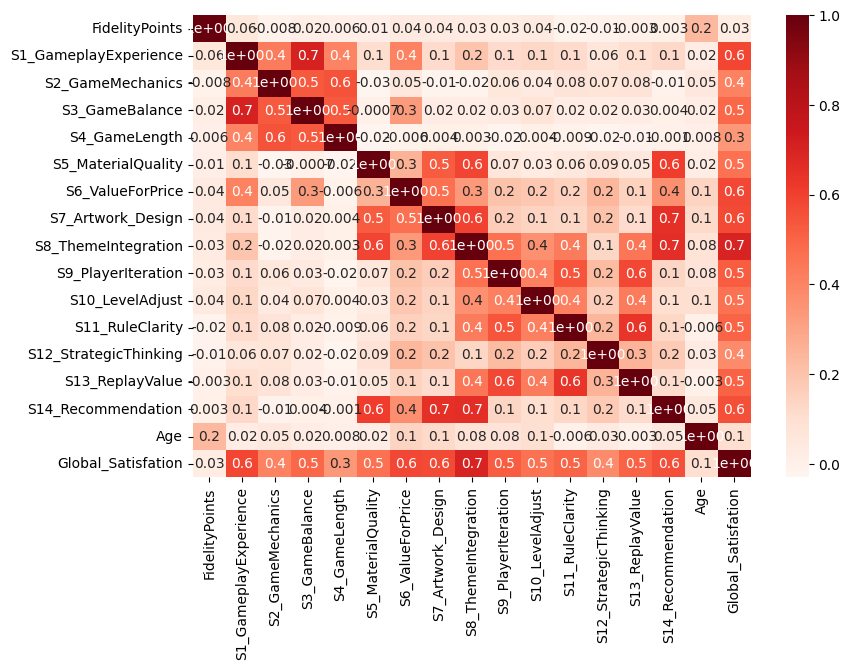

_________________________________________________________________________________________________

                                     SPLIT 10                                    
_________________________________________________________________________________________________


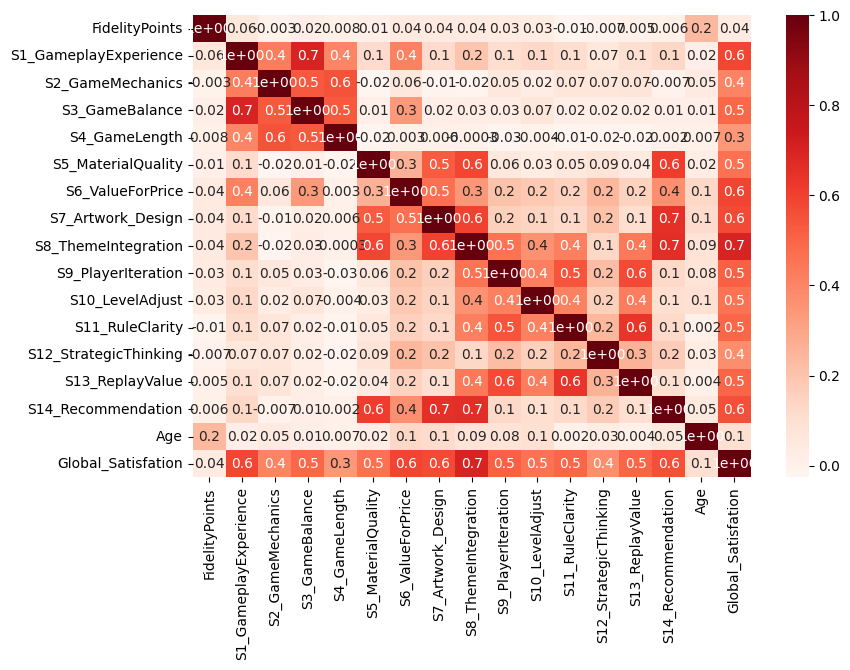

In [72]:
redundant_features(X, y)

#### 2.8.2.3 Decision Trees (Embedded Method) - For continuous, ordinal and binary data

In [73]:
def apply_dt(X_train, y_train):
    dt = DecisionTreeClassifier(random_state = 99).fit(X_train, y_train)
    feature_importances = pd.Series(dt.feature_importances_, index = X_train.columns)
    plot_importance(feature_importances, 'DT')

#### 2.8.2.4 Recursive Feature Elimination (RFE) (Wrapper Method) - For continuous, ordinal and binary data

In [74]:
def apply_rfe(X_train, y_train):
    rfe = RFE(estimator = LogisticRegression(), n_features_to_select = 5)
    rfe.fit_transform(X = X_train, y = y_train)
    selected_features = pd.Series(rfe.support_, index = X_train.columns)
    print(selected_features)

#### 2.8.2.5 Lasso - For continuous and ordinal data

In [79]:
def apply_lasso(X_train, y_train):
    X_train = X_train.drop(['Male', 'Membership_Premium', 'Newsletter_Subscription'], axis = 1)
    lasso = LassoCV().fit(X_train, y_train)
    coef = pd.Series(lasso.coef_, index = X_train.columns)
    plot_importance(coef,'Lasso')

#### 2.8.2.6 Run RFE, Lasso and DT

In [80]:
def select_best_features(X,y):
    count = 1
    for train_index, val_index in skf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        ########################################### SCALE DATA ####################################################
        numerical_data = X_train.drop(['Preferred_Game_Genre'], axis = 1).copy()
        scaler = MinMaxScaler().fit(numerical_data)
        X_train_scaled = scaler.transform(numerical_data)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns = numerical_data.columns)

        ######################################### SELECT FEATURES #################################################
        print('_________________________________________________________________________________________________\n')
        print('                                     SPLIT ' + str(count) + '                                    ')
        print('_________________________________________________________________________________________________')

        # Check which features to use using RFE
        print('')
        print('----------------- RFE ----------------------')
        apply_rfe(X_train_scaled, y_train)

        # check which features to use using lasso
        print('')
        print('----------------- LASSO ----------------------')
        apply_lasso(X_train_scaled, y_train)

        # check which features to use using lasso
        print('')
        print('----------------- DT ----------------------')
        apply_dt(X_train_scaled, y_train)

        count+=1

In [81]:
def plot_importance(variables,name):
    imp_features = variables.sort_values()
    plt.figure(figsize=(4,5))
    imp_features.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

_________________________________________________________________________________________________

                                     SPLIT 1                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
FidelityPoints             False
S1_GameplayExperience      False
S2_GameMechanics            True
S3_GameBalance              True
S4_GameLength              False
S5_MaterialQuality         False
S6_ValueForPrice            True
S7_Artwork_Design          False
S8_ThemeIntegration        False
S9_PlayerIteration         False
S10_LevelAdjust            False
S11_RuleClarity            False
S12_StrategicThinking      False
S13_ReplayValue            False
S14_Recommendation         False
Male                       False
Age                        False
Global_Satisfation          True
Membership_Premium         False
Newsletter_Subscription     True
dtype: bool

---

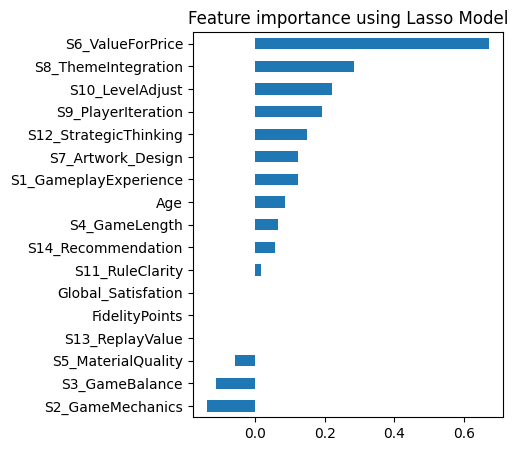


----------------- DT ----------------------


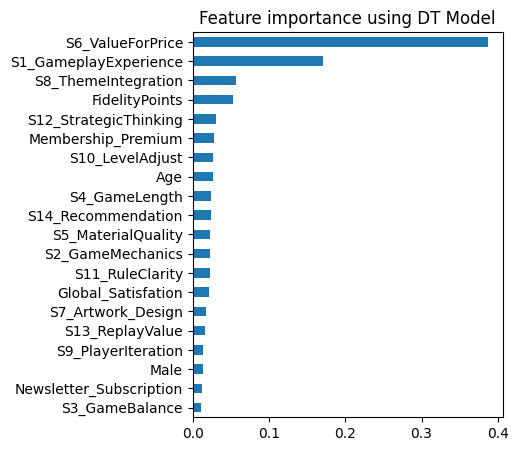

_________________________________________________________________________________________________

                                     SPLIT 2                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
FidelityPoints             False
S1_GameplayExperience      False
S2_GameMechanics           False
S3_GameBalance             False
S4_GameLength              False
S5_MaterialQuality         False
S6_ValueForPrice            True
S7_Artwork_Design          False
S8_ThemeIntegration         True
S9_PlayerIteration          True
S10_LevelAdjust             True
S11_RuleClarity            False
S12_StrategicThinking      False
S13_ReplayValue            False
S14_Recommendation         False
Male                       False
Age                        False
Global_Satisfation         False
Membership_Premium         False
Newsletter_Subscription     True
dtype: bool

---

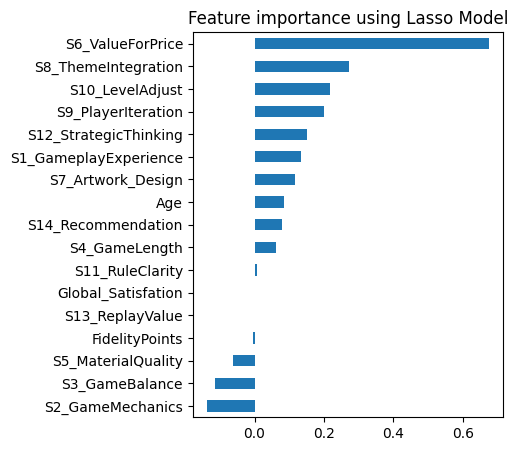


----------------- DT ----------------------


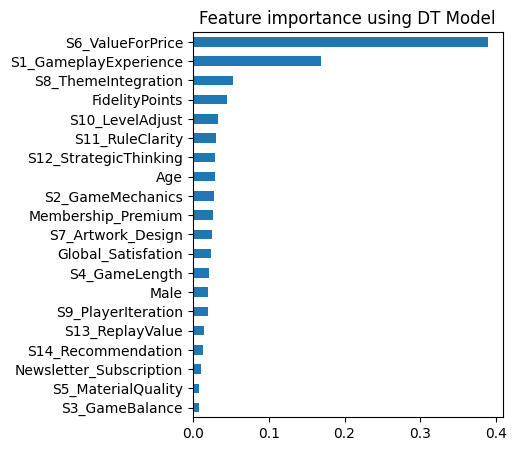

_________________________________________________________________________________________________

                                     SPLIT 3                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
FidelityPoints             False
S1_GameplayExperience      False
S2_GameMechanics           False
S3_GameBalance             False
S4_GameLength              False
S5_MaterialQuality         False
S6_ValueForPrice            True
S7_Artwork_Design          False
S8_ThemeIntegration         True
S9_PlayerIteration         False
S10_LevelAdjust             True
S11_RuleClarity            False
S12_StrategicThinking       True
S13_ReplayValue            False
S14_Recommendation         False
Male                       False
Age                        False
Global_Satisfation         False
Membership_Premium         False
Newsletter_Subscription     True
dtype: bool

---

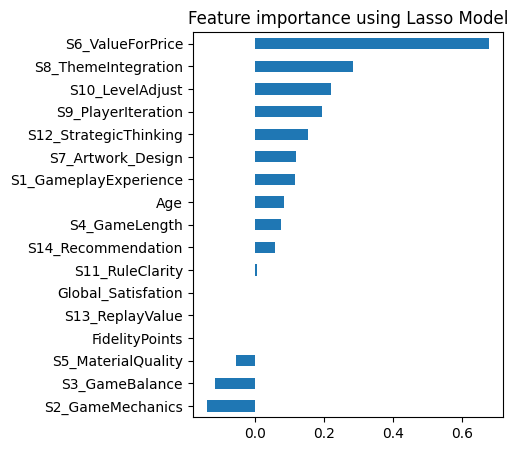


----------------- DT ----------------------


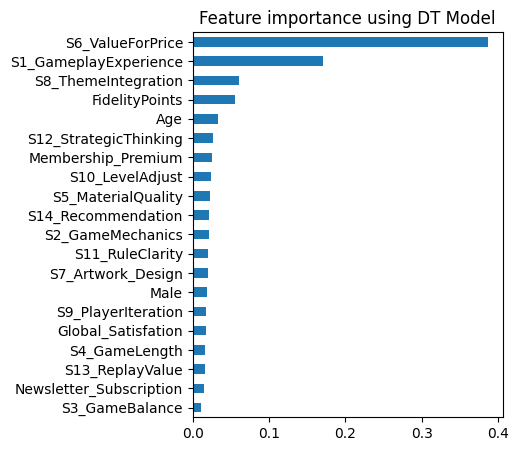

_________________________________________________________________________________________________

                                     SPLIT 4                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
FidelityPoints             False
S1_GameplayExperience      False
S2_GameMechanics           False
S3_GameBalance             False
S4_GameLength              False
S5_MaterialQuality         False
S6_ValueForPrice            True
S7_Artwork_Design          False
S8_ThemeIntegration         True
S9_PlayerIteration          True
S10_LevelAdjust             True
S11_RuleClarity            False
S12_StrategicThinking      False
S13_ReplayValue            False
S14_Recommendation         False
Male                       False
Age                        False
Global_Satisfation         False
Membership_Premium         False
Newsletter_Subscription     True
dtype: bool

---

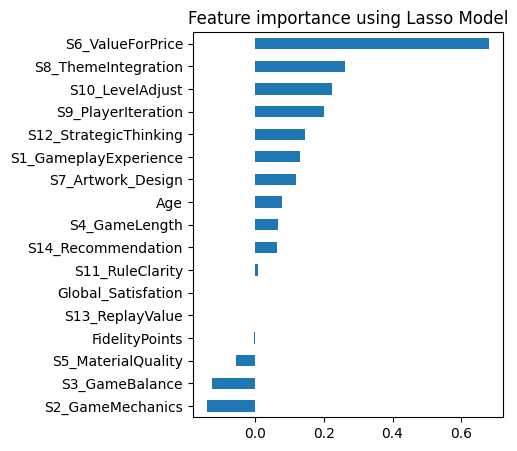


----------------- DT ----------------------


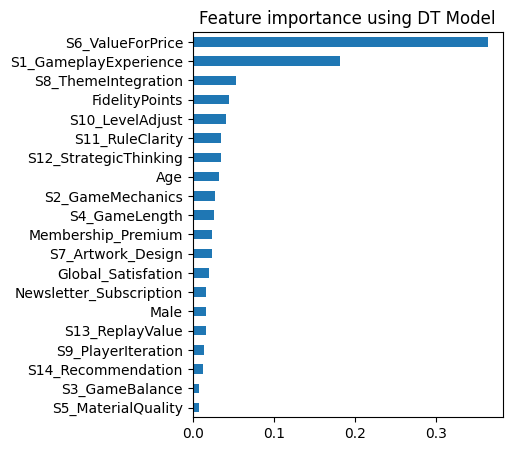

_________________________________________________________________________________________________

                                     SPLIT 5                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
FidelityPoints             False
S1_GameplayExperience      False
S2_GameMechanics           False
S3_GameBalance             False
S4_GameLength              False
S5_MaterialQuality         False
S6_ValueForPrice            True
S7_Artwork_Design          False
S8_ThemeIntegration         True
S9_PlayerIteration         False
S10_LevelAdjust             True
S11_RuleClarity            False
S12_StrategicThinking       True
S13_ReplayValue            False
S14_Recommendation         False
Male                       False
Age                        False
Global_Satisfation         False
Membership_Premium         False
Newsletter_Subscription     True
dtype: bool

---

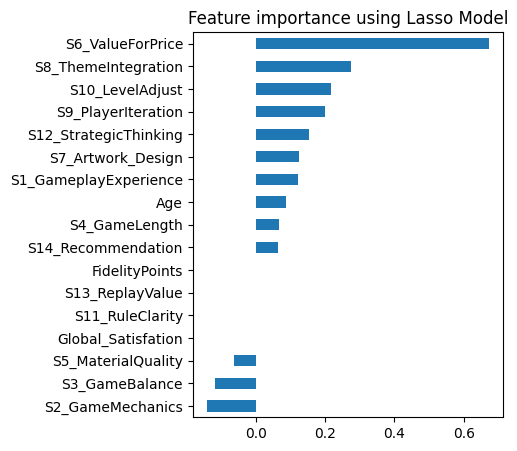


----------------- DT ----------------------


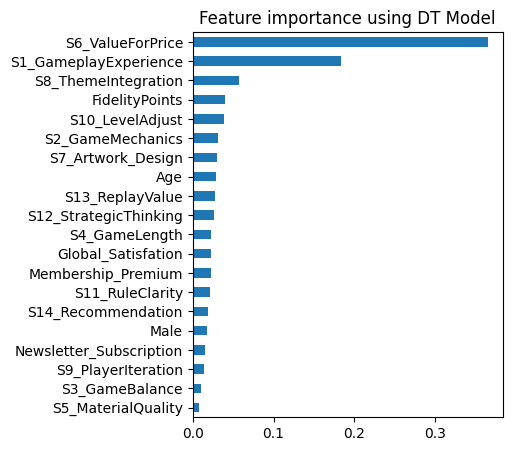

_________________________________________________________________________________________________

                                     SPLIT 6                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
FidelityPoints             False
S1_GameplayExperience      False
S2_GameMechanics           False
S3_GameBalance             False
S4_GameLength              False
S5_MaterialQuality         False
S6_ValueForPrice            True
S7_Artwork_Design          False
S8_ThemeIntegration         True
S9_PlayerIteration         False
S10_LevelAdjust             True
S11_RuleClarity            False
S12_StrategicThinking       True
S13_ReplayValue            False
S14_Recommendation         False
Male                       False
Age                        False
Global_Satisfation         False
Membership_Premium         False
Newsletter_Subscription     True
dtype: bool

---

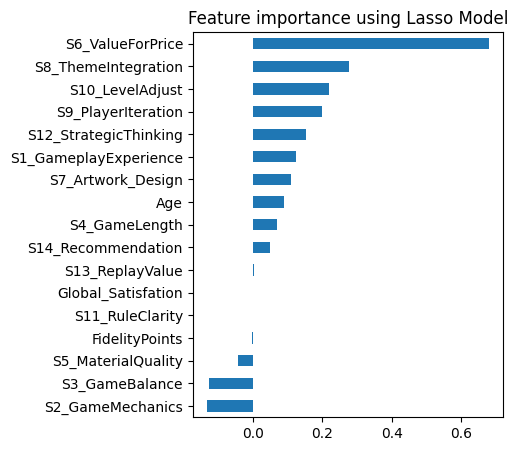


----------------- DT ----------------------


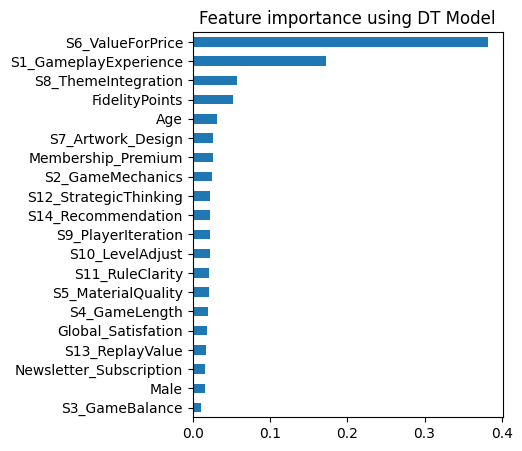

_________________________________________________________________________________________________

                                     SPLIT 7                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
FidelityPoints             False
S1_GameplayExperience      False
S2_GameMechanics            True
S3_GameBalance              True
S4_GameLength              False
S5_MaterialQuality         False
S6_ValueForPrice            True
S7_Artwork_Design          False
S8_ThemeIntegration        False
S9_PlayerIteration         False
S10_LevelAdjust            False
S11_RuleClarity            False
S12_StrategicThinking      False
S13_ReplayValue            False
S14_Recommendation         False
Male                       False
Age                        False
Global_Satisfation          True
Membership_Premium         False
Newsletter_Subscription     True
dtype: bool

---

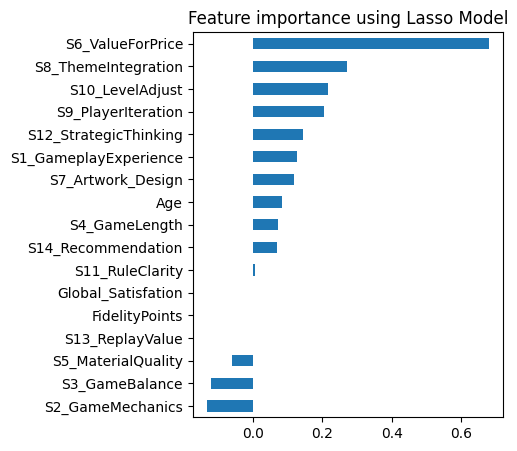


----------------- DT ----------------------


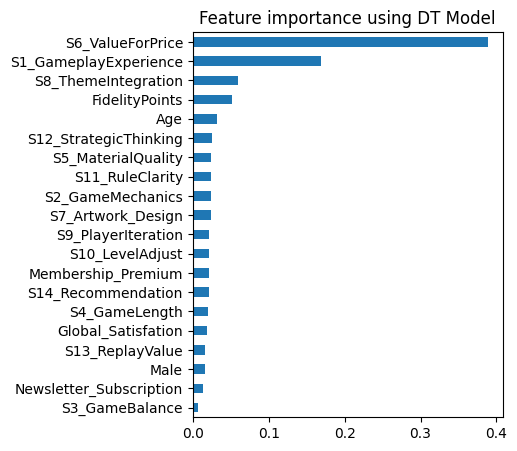

_________________________________________________________________________________________________

                                     SPLIT 8                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
FidelityPoints             False
S1_GameplayExperience      False
S2_GameMechanics            True
S3_GameBalance              True
S4_GameLength              False
S5_MaterialQuality         False
S6_ValueForPrice            True
S7_Artwork_Design          False
S8_ThemeIntegration        False
S9_PlayerIteration         False
S10_LevelAdjust            False
S11_RuleClarity            False
S12_StrategicThinking      False
S13_ReplayValue            False
S14_Recommendation         False
Male                       False
Age                        False
Global_Satisfation          True
Membership_Premium         False
Newsletter_Subscription     True
dtype: bool

---

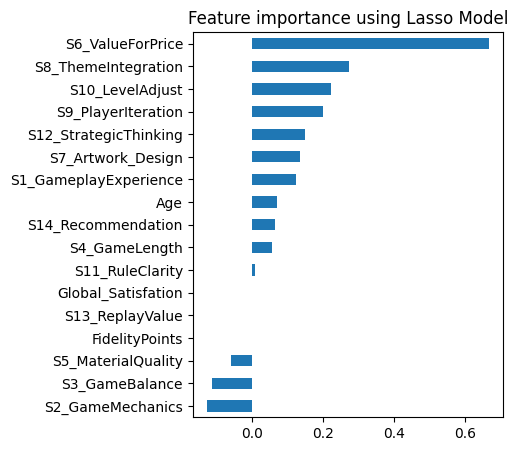


----------------- DT ----------------------


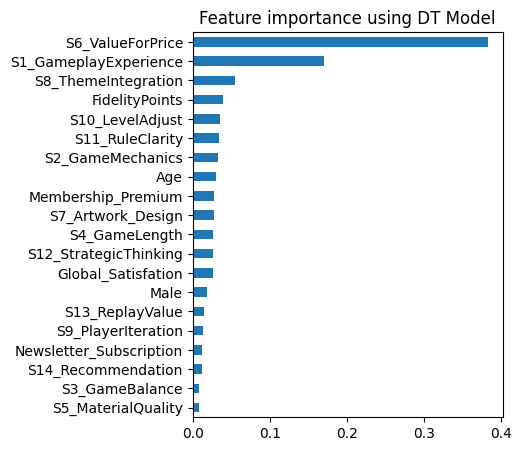

_________________________________________________________________________________________________

                                     SPLIT 9                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
FidelityPoints             False
S1_GameplayExperience      False
S2_GameMechanics            True
S3_GameBalance              True
S4_GameLength              False
S5_MaterialQuality         False
S6_ValueForPrice            True
S7_Artwork_Design          False
S8_ThemeIntegration        False
S9_PlayerIteration         False
S10_LevelAdjust            False
S11_RuleClarity            False
S12_StrategicThinking      False
S13_ReplayValue            False
S14_Recommendation         False
Male                       False
Age                        False
Global_Satisfation          True
Membership_Premium         False
Newsletter_Subscription     True
dtype: bool

---

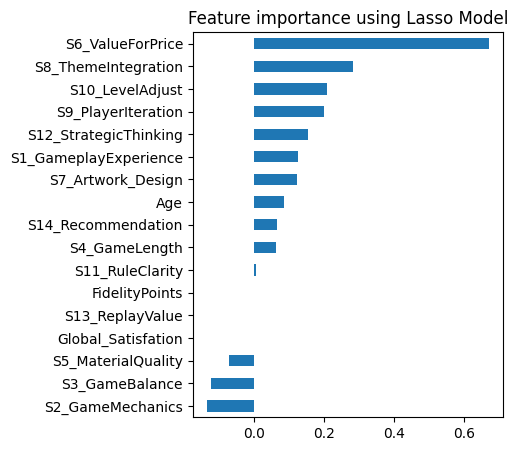


----------------- DT ----------------------


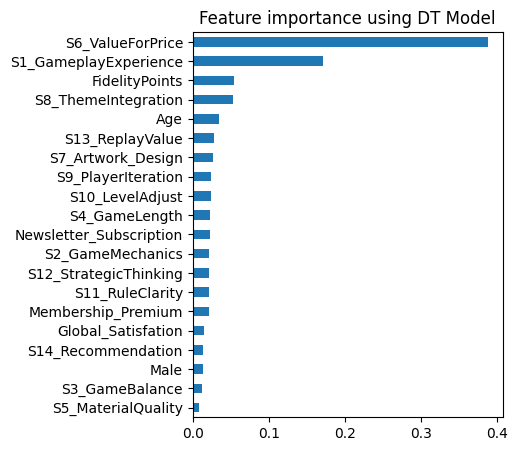

_________________________________________________________________________________________________

                                     SPLIT 10                                    
_________________________________________________________________________________________________

----------------- RFE ----------------------
FidelityPoints             False
S1_GameplayExperience      False
S2_GameMechanics           False
S3_GameBalance             False
S4_GameLength              False
S5_MaterialQuality         False
S6_ValueForPrice            True
S7_Artwork_Design          False
S8_ThemeIntegration         True
S9_PlayerIteration         False
S10_LevelAdjust             True
S11_RuleClarity            False
S12_StrategicThinking       True
S13_ReplayValue            False
S14_Recommendation         False
Male                       False
Age                        False
Global_Satisfation         False
Membership_Premium         False
Newsletter_Subscription     True
dtype: bool

--

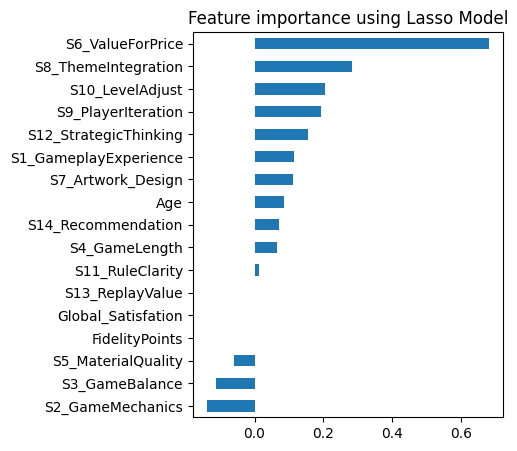


----------------- DT ----------------------


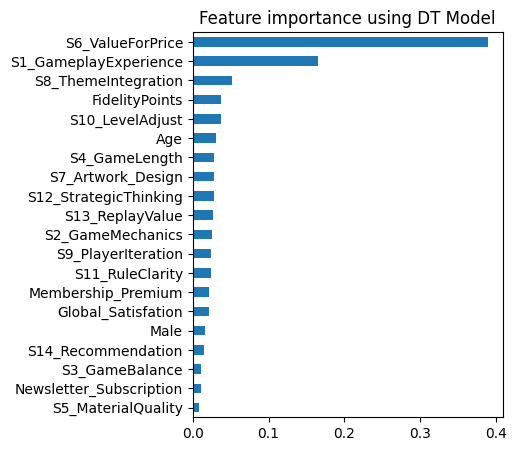

In [82]:
select_best_features(X, y)

#### 2.8.2.7 Random Forest

In [83]:
def plot_importance(variables, name, subplot_index):
    imp_features = variables.sort_values()
    plt.subplot(1, 5, subplot_index)  # Adjust the subplot settings accordingly
    imp_features.plot(kind="barh", color='green')  # Set color to green
    plt.title("Split " + str(subplot_index))  # Set subplot title to split number
    plt.xticks(fontsize=8)  # Decrease the size of the x-axis labels
    plt.tight_layout()

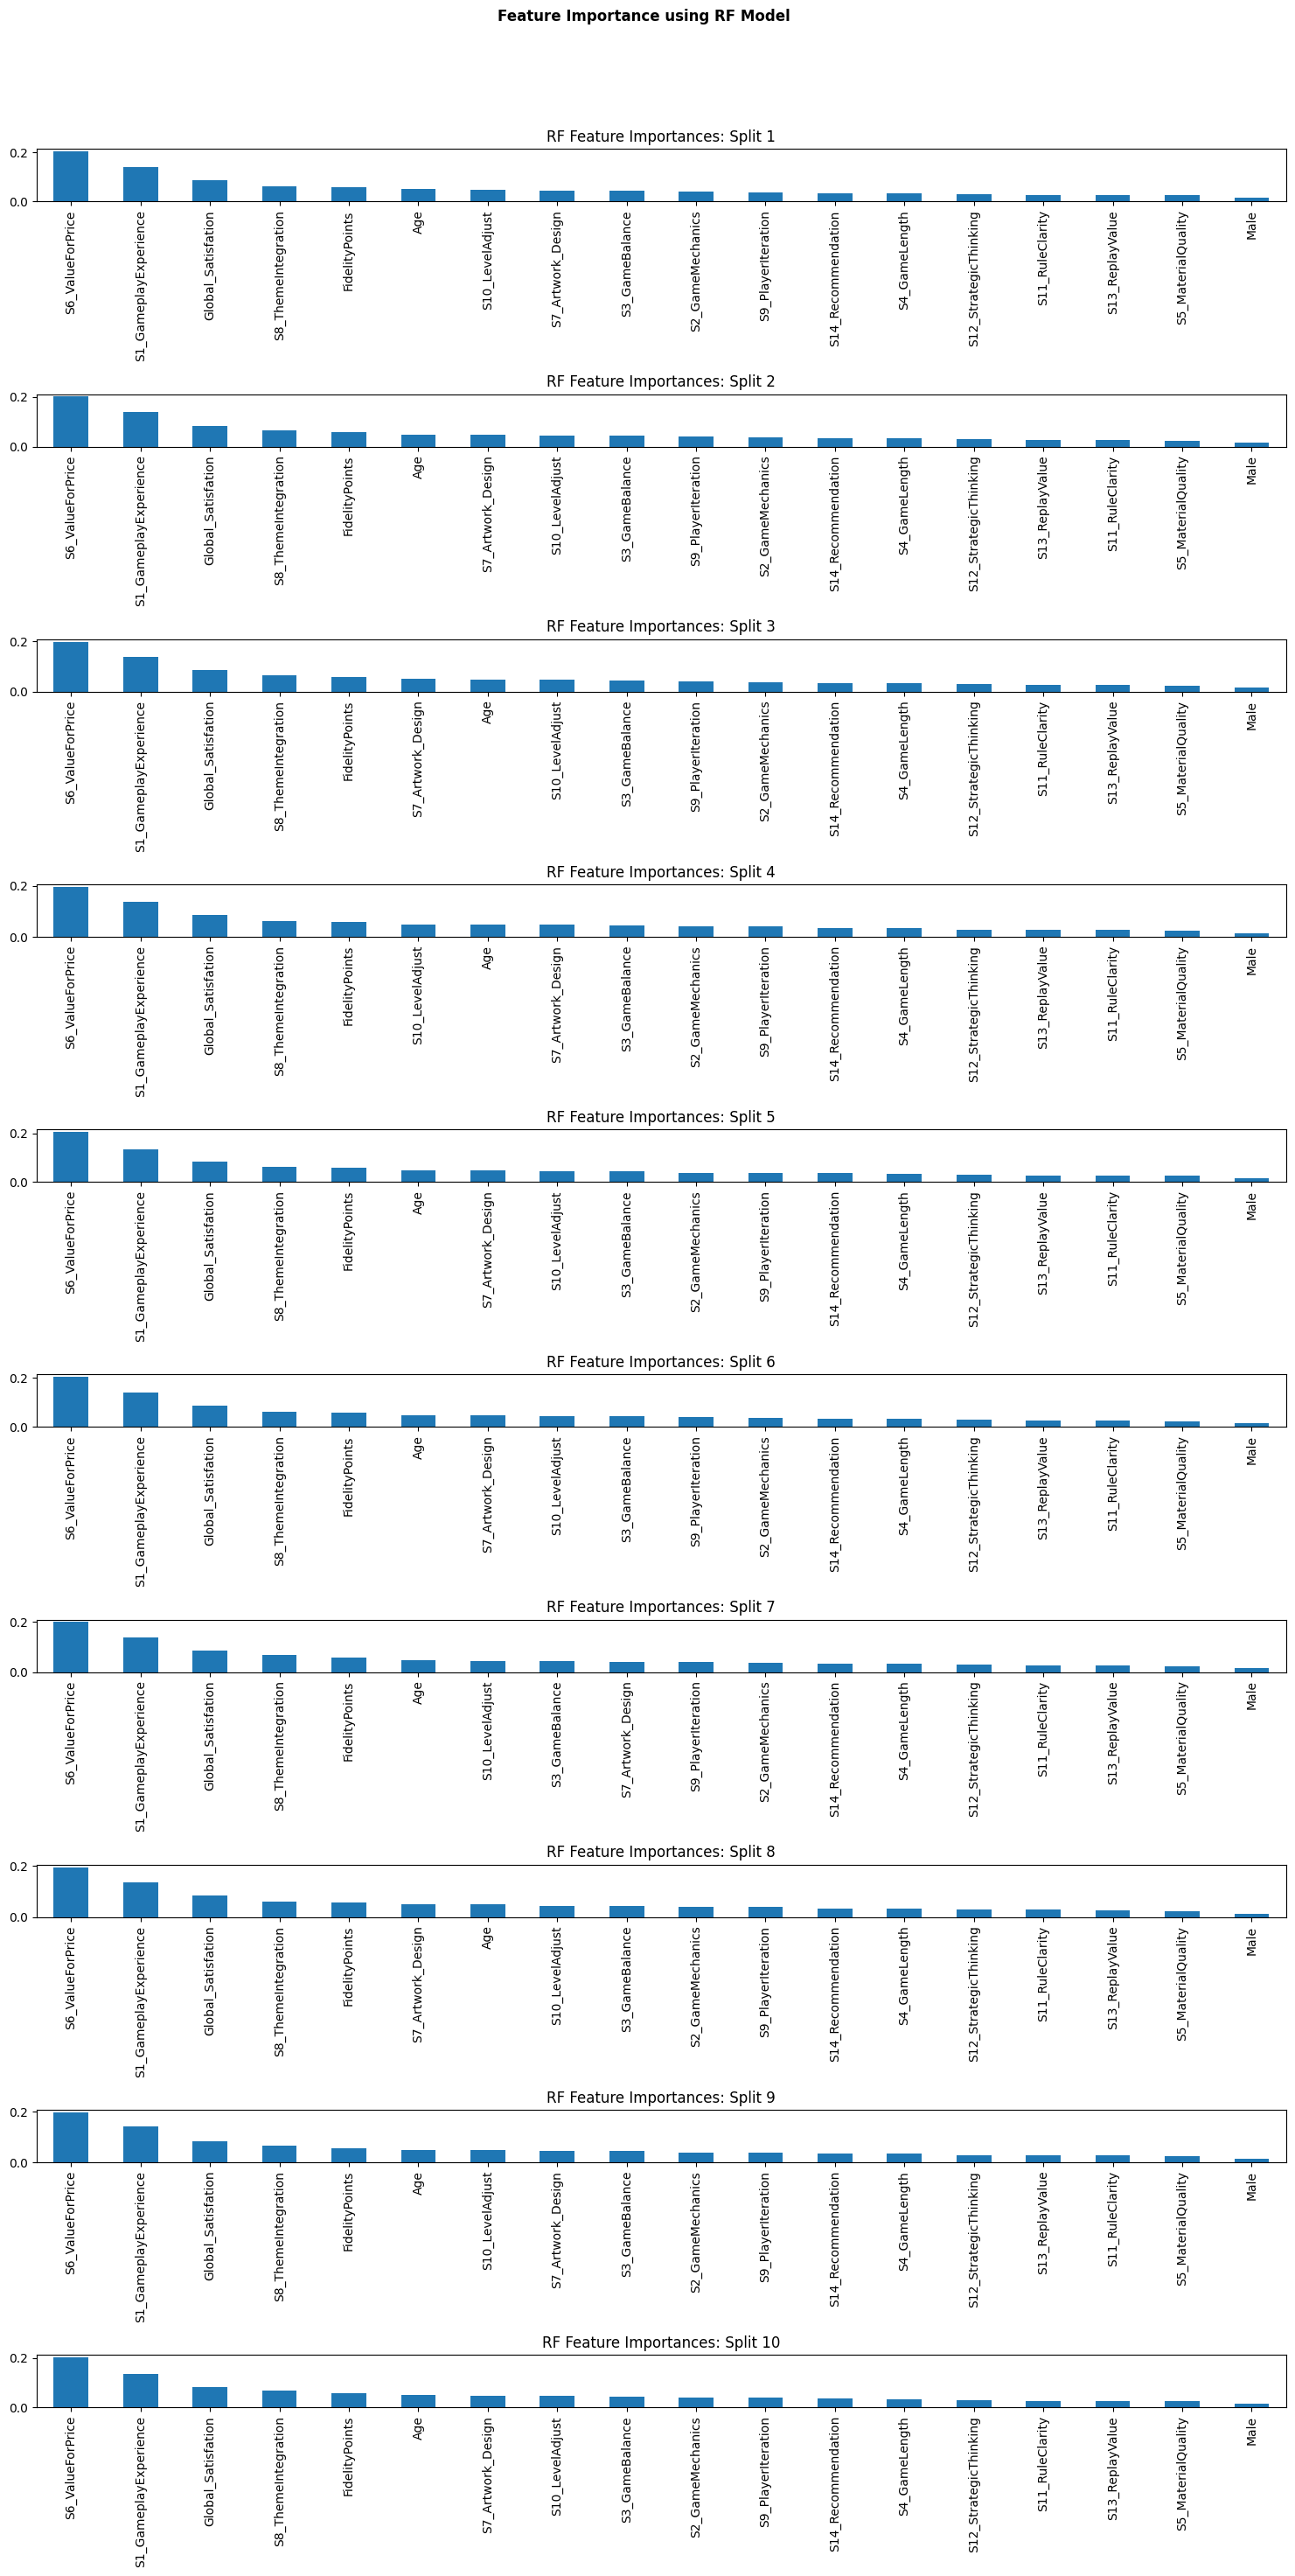

S6_ValueForPrice           0.200333
S1_GameplayExperience      0.137386
Global_Satisfation         0.085030
S8_ThemeIntegration        0.064272
FidelityPoints             0.057851
Age                        0.048878
S7_Artwork_Design          0.047045
S10_LevelAdjust            0.046207
S3_GameBalance             0.043667
S9_PlayerIteration         0.039076
S2_GameMechanics           0.038904
S14_Recommendation         0.035259
S4_GameLength              0.033267
S12_StrategicThinking      0.028949
S13_ReplayValue            0.027133
S11_RuleClarity            0.026854
S5_MaterialQuality         0.025150
Male                       0.014738
Preferred_Game_Genre            NaN
Membership_Premium              NaN
Newsletter_Subscription         NaN
Name: Average Score, dtype: float64


In [95]:
from sklearn.ensemble import RandomForestClassifier

def plot_importance(feature_importances, model_name, subplot_index, total_subplots, count):
    plt.subplot(total_subplots, 1, subplot_index)
    feature_importances.sort_values(ascending=False).plot(kind='bar', title=f'{model_name} Feature Importances: Split {count}')

def apply_rf(X_train, y_train, subplot_index, total_subplots, count):
    rf = RandomForestClassifier(criterion='entropy', random_state=99).fit(X_train, y_train)
    feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    plot_importance(feature_importances, 'RF', subplot_index, total_subplots, count)
    return feature_importances

def select_best_features_rf(X, y):
    count = 1
    n_splits = 10
    fig = plt.figure(figsize=(15, 30))  # Create a figure to contain the subplots with adjusted size for more subplots
    skf = StratifiedKFold(n_splits=n_splits, random_state=99, shuffle=True)
    ranking_scores = pd.DataFrame(index=X.columns)  # Create a DataFrame to store the ranking scores

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Select numerical features for random forest
        X_train_num = X_train.select_dtypes(include=[np.number])

        # Scale the numerical features
        scaler = MinMaxScaler().fit(X_train_num)
        X_train_scaled = scaler.transform(X_train_num)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_num.columns)

        # Apply random forest to scaled numerical features
        feature_importances = apply_rf(X_train_scaled, y_train, count, n_splits, count)

        # Store the feature importances in the ranking_scores DataFrame
        ranking_scores[f'Split {count}'] = feature_importances

        count += 1

    plt.suptitle("Feature Importance using RF Model", fontsize=12, fontweight='bold')  # Overall title above the subplots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust the layout of the subplots and overall title
    plt.show()

    # Calculate the average ranking score across all splits
    ranking_scores['Average Score'] = ranking_scores.mean(axis=1)
    average_ranking = ranking_scores['Average Score'].sort_values(ascending=False)
    print(average_ranking)

# Assuming X and y are defined as your data and target
select_best_features_rf(X, y)


#### 2.8.2.8 Forward Selection (SFS)

In [97]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

def apply_sfs(X, y, skf, n_features_to_select):
    '''
    Returns a dataframe with the count of selected features by SFS across the K-Fold splits

    Args:
        X (pandas.dataframe) - Variables
        y (pandas.dataframe) - Target
        skf (object) - StratifiedKFold instance
        n_features_to_select (int) - Number of features to select

    Returns:
        pandas.dataframe
    '''
    df = pd.DataFrame()
    df['Features'] = X.columns
    sfs_feat_count = {}  # Dictionary to store counts for SFS

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Select numerical features
        X_train_num = X_train.select_dtypes(include=[np.number])

        ########## Scale the numerical features using MinMaxScaler ##########
        scaler = MinMaxScaler().fit(X_train_num)
        X_train_scaled = scaler.transform(X_train_num)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_num.columns)

        # Apply SFS on scaled data
        sfs = SFS(RandomForestClassifier(), k_features=n_features_to_select)
        sfs.fit(X_train_scaled, y_train)
        selected_features_sfs = pd.Series(sfs.k_feature_names_, index=sfs.k_feature_idx_)

        # Accumulate the counts of selected features for SFS
        for feature in selected_features_sfs:
            if feature in sfs_feat_count:
                sfs_feat_count[feature] += 1
            else:
                sfs_feat_count[feature] = 1

    df['SFS_Significant_Count'] = df['Features'].apply(lambda x: sfs_feat_count.get(x, 0))

    # Add 'Wrapper_SFS' column
    df['Wrapper_SFS'] = df.apply(lambda row: 'Keep' if row['SFS_Significant_Count'] >= 2 else 'Remove', axis=1)
    df.loc[df['Features'].apply(lambda x: X[x].dtypes not in [np.number, np.float64, np.int64]), 'Wrapper_SFS'] = ''

    return df

# Prepare StratifiedKFold instance
skf = StratifiedKFold(n_splits=10, random_state=99, shuffle=True)

sfs_results = apply_sfs(X, y, skf, n_features_to_select=10)
sfs_results

Features  SFS_Significant_Count Wrapper_SFS
0      Preferred_Game_Genre                      0            
1            FidelityPoints                      2        Keep
2     S1_GameplayExperience                     10        Keep
3          S2_GameMechanics                     10        Keep
4            S3_GameBalance                      9        Keep
5             S4_GameLength                     10        Keep
6        S5_MaterialQuality                      0      Remove
7          S6_ValueForPrice                     10        Keep
8         S7_Artwork_Design                      2        Keep
9       S8_ThemeIntegration                     10        Keep
10       S9_PlayerIteration                      1      Remove
11          S10_LevelAdjust                      5        Keep
12          S11_RuleClarity                     10        Keep
13    S12_StrategicThinking                      3        Keep
14          S13_ReplayValue                     10        Keep
15       S14_Recommendation                      1      Remove
16                     Male                      0      Remove
17                      Age                      0      Remove
18       Global_Satisfation                      7        Keep
19       Membership_Premium                      0            
20  Newsletter_Subscription                      0